# Electricity Demand Forecasting — Classical Time Series Models
**Data**: Monthly electricity consumption (KWh) | Jan 2019 – Jan 2026  
**Goal**: Forecast next 3 months using classical time series models tracked via MLflow  
**Model Progression**: Baseline → Simple Exponential Smoothing → Holt's Linear → Holt-Winters (Additive/Multiplicative/Damped) → ARIMA → SARIMA


## 1. Imports & Configuration

In [1]:
!pip install statsmodels pmdarima mlflow scikit-learn seaborn


In [2]:
import warnings
import pickle
import os
import tempfile
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm

import mlflow
import mlflow.statsmodels
import mlflow.pyfunc

warnings.filterwarnings("ignore")
plt.rcParams.update({"figure.dpi": 120, "figure.figsize": (12, 4)})

RANDOM_SEED = 42
FORECAST_HORIZON = 3   # months ahead
SEASONAL_PERIOD  = 12  # monthly seasonality
MLFLOW_TRACKING_URI = "mlruns"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print("MLflow tracking URI:", mlflow.get_tracking_uri())


MLflow tracking URI: mlruns


## 2. Data Loading & Preprocessing

In [3]:
RAW_DATA = {
    "month_year": [
        "2019-01-01","2019-02-01","2019-03-01","2019-04-01","2019-05-01","2019-06-01",
        "2019-07-01","2019-08-01","2019-09-01","2019-10-01","2019-11-01","2019-12-01",
        "2020-01-01","2020-02-01","2020-03-01","2020-04-01","2020-05-01","2020-06-01",
        "2020-07-01","2020-08-01","2020-09-01","2020-10-01","2020-11-01","2020-12-01",
        "2021-01-01","2021-02-01","2021-03-01","2021-04-01","2021-05-01","2021-06-01",
        "2021-07-01","2021-08-01","2021-09-01","2021-10-01","2021-11-01","2021-12-01",
        "2022-01-01","2022-02-01","2022-03-01","2022-04-01","2022-05-01","2022-06-01",
        "2022-07-01","2022-08-01","2022-09-01","2022-10-01","2022-11-01","2022-12-01",
        "2023-01-01","2023-02-01","2023-03-01","2023-04-01","2023-05-01","2023-06-01",
        "2023-07-01","2023-08-01","2023-09-01","2023-10-01","2023-11-01","2023-12-01",
        "2024-01-01","2024-02-01","2024-03-01","2024-04-01","2024-05-01","2024-06-01",
        "2024-07-01","2024-08-01","2024-09-01","2024-10-01","2024-11-01","2024-12-01",
        "2025-01-01","2025-02-01","2025-03-01","2025-04-01","2025-05-01","2025-06-01",
        "2025-07-01","2025-08-01","2025-09-01","2025-10-01","2025-11-01","2025-12-01",
        "2026-01-01",
    ],
    "total_units_kwh": [
        199722489.0,196282917.0,229630601.0,307610021.0,378333246.0,386806926.0,
        318453165.0,303440777.0,299577754.0,302758063.0,287854703.0,249393096.0,
        226911059.0,233987135.0,249055256.0,311844901.0,378972626.0,371104608.0,
        362331096.0,376818006.5,349757651.6,342309639.0,317955772.0,269855118.0,
        243155839.6,253523091.0,263214583.0,339192666.0,405477414.0,2158077.0,   # outlier
        368050250.0,384068332.0,361304647.0,350300159.0,326220132.17,284013708.0,
        243976433.0,236413333.11,260031223.0,371437583.28,424833878.1,443537503.0,
        376807680.32,322593689.64,351653428.59,332648965.59,294138231.0,249154006.57,
        259018866.16,255718830.0,262851784.0,341098867.0,373179111.0,468056532.0,
        414786578.0,340837857.0,380861584.0,348924442.0,346219332.0,295555199.0,
        240950774.0,288656864.0,296623052.0,389765964.0,467155674.0,276370652.0,
        429853045.0,385815658.0,417634123.0,388451915.0,402365044.0,301822337.0,
        292729563.0,303704651.0,328929748.0,427534816.0,485839957.0,498140707.0,
        442414161.0,432117294.0,416787169.0,414938105.0,390481404.0,290133269.0,
        273816782.0,
    ],
}

df = pd.DataFrame(RAW_DATA)
df["month_year"] = pd.to_datetime(df["month_year"])
df = df.set_index("month_year")
df.index.freq = "MS"

print(f"Shape: {df.shape}")
print(f"Date range: {df.index.min()} → {df.index.max()}")
print(f"\nNull values:\n{df.isnull().sum()}")
df.head()


Shape: (85, 1)
Date range: 2019-01-01 00:00:00 → 2026-01-01 00:00:00

Null values:
total_units_kwh    0
dtype: int64


,total_units_kwh
month_year,
2019-01-01,199722489.0
2019-02-01,196282917.0
2019-03-01,229630601.0
2019-04-01,307610021.0
2019-05-01,378333246.0


## 3. Outlier Fix — 2021-06

Original 2021-06 value : 2,158,077 KWh  ← data entry error
Imputed  2021-06 value : 386,457,052 KWh  ← interpolated


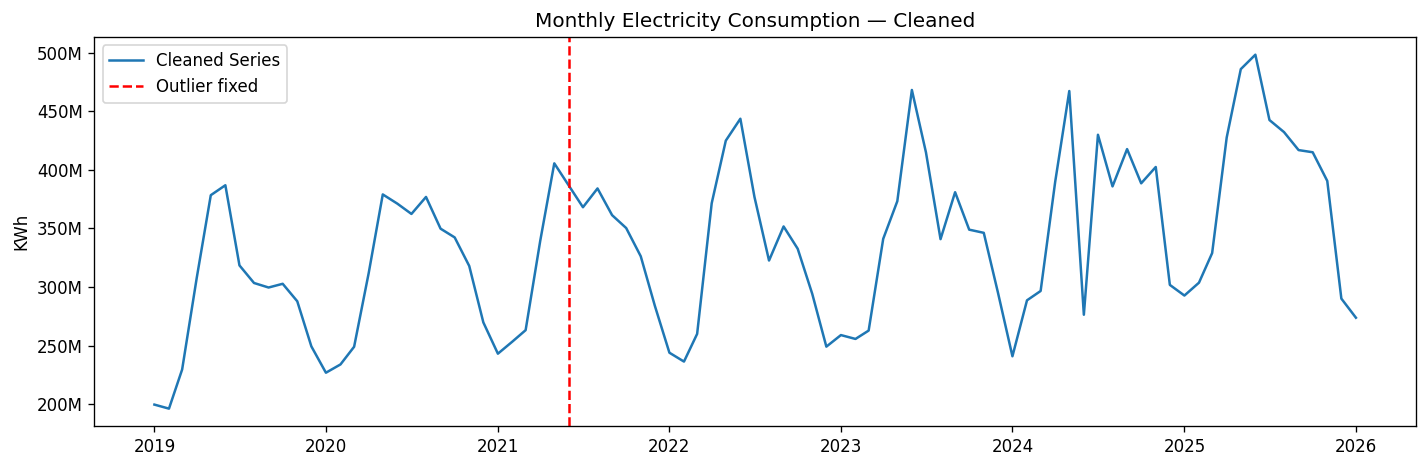

Plot saved: 01_cleaned_series.png


In [4]:
OUTLIER_DATE = "2021-06-01"
original_value = df.loc[OUTLIER_DATE, "total_units_kwh"]
print(f"Original 2021-06 value : {original_value:,.0f} KWh  ← data entry error")

# Replace with NaN and interpolate using time-based method
df.loc[OUTLIER_DATE, "total_units_kwh"] = np.nan
df["total_units_kwh"] = df["total_units_kwh"].interpolate(method="time")

imputed_value = df.loc[OUTLIER_DATE, "total_units_kwh"]
print(f"Imputed  2021-06 value : {imputed_value:,.0f} KWh  ← interpolated")

# Visual confirmation
fig, ax = plt.subplots()
ax.plot(df.index, df["total_units_kwh"], label="Cleaned Series", linewidth=1.5)
ax.axvline(pd.Timestamp(OUTLIER_DATE), color="red", linestyle="--", label="Outlier fixed")
ax.set_title("Monthly Electricity Consumption — Cleaned")
ax.set_ylabel("KWh")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
ax.legend()
plt.tight_layout()
plt.savefig("01_cleaned_series.png", bbox_inches="tight")
plt.show()
print("Plot saved: 01_cleaned_series.png")


## 4. Exploratory Data Analysis

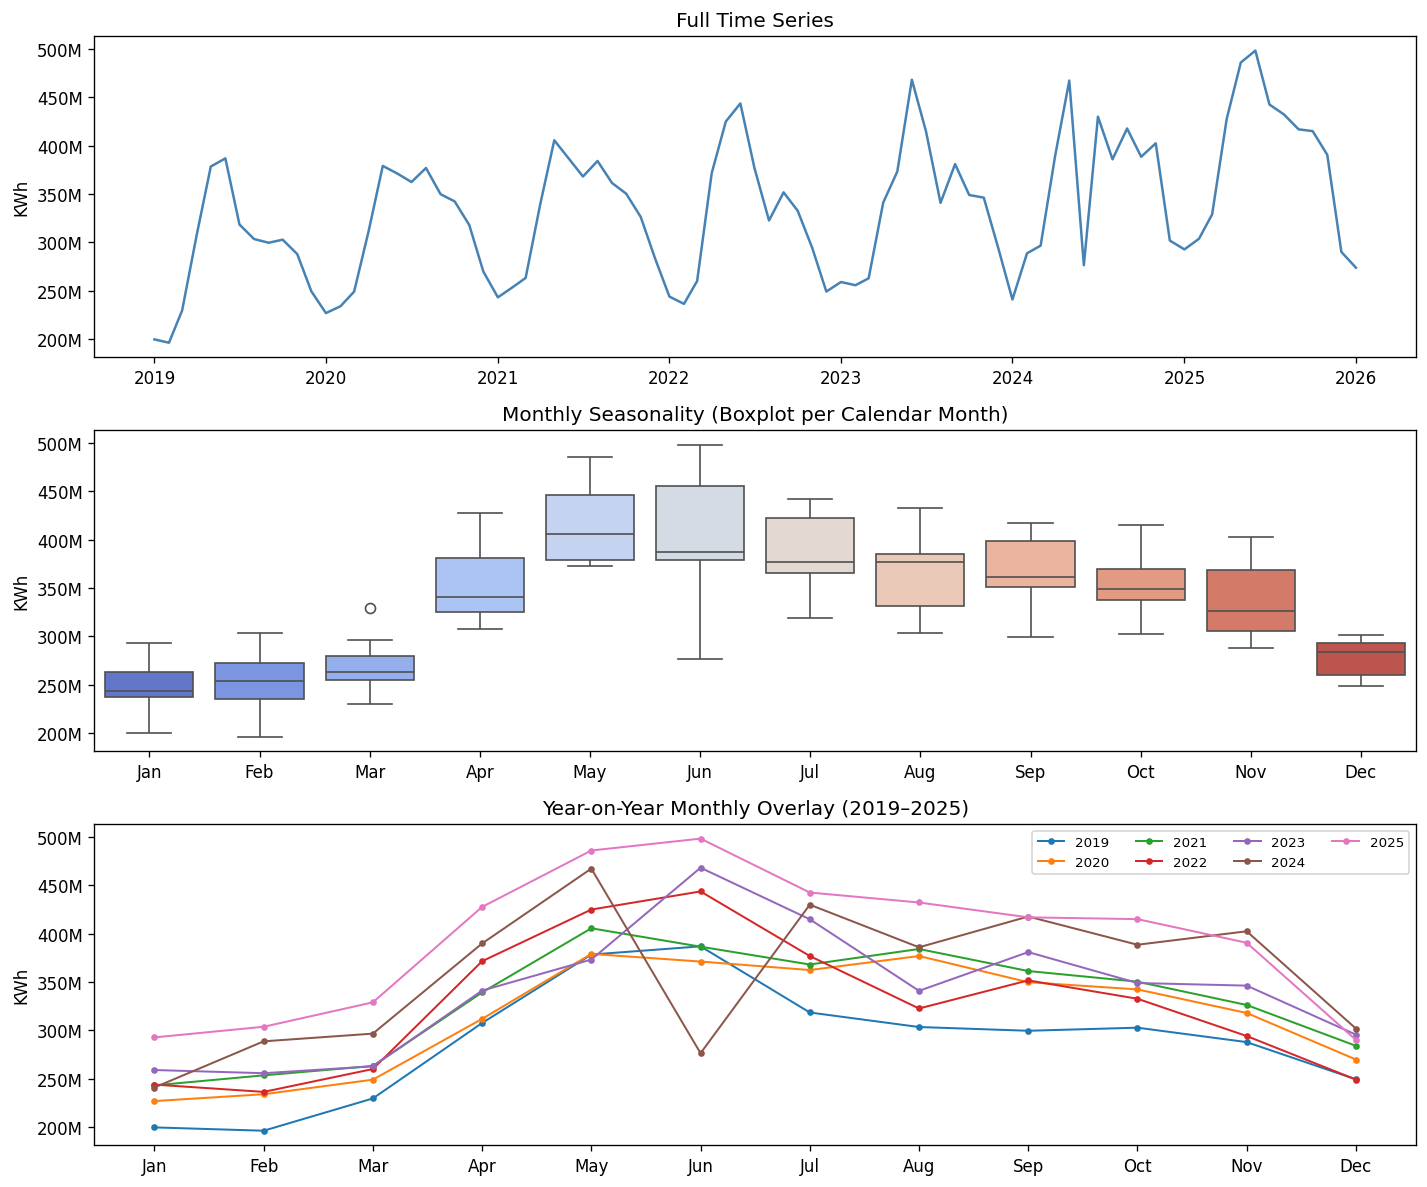

Plot saved: 02_eda.png


In [5]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# 4.1 Full series
axes[0].plot(df.index, df["total_units_kwh"], linewidth=1.5, color="steelblue")
axes[0].set_title("Full Time Series")
axes[0].set_ylabel("KWh")
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))

# 4.2 Monthly seasonality boxplot
df_eda = df.copy()
df_eda["month"] = df_eda.index.month
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
df_eda["month_name"] = df_eda["month"].apply(lambda m: month_labels[m - 1])
month_order = month_labels
sns.boxplot(
    data=df_eda, x="month_name", y="total_units_kwh",
    order=month_order, ax=axes[1], palette="coolwarm"
)
axes[1].set_title("Monthly Seasonality (Boxplot per Calendar Month)")
axes[1].set_ylabel("KWh")
axes[1].set_xlabel("")
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))

# 4.3 Year-on-year overlay
df_eda["year"] = df_eda.index.year
pivot = df_eda[df_eda["year"] <= 2025].pivot_table(
    index="month", columns="year", values="total_units_kwh"
)
for col in pivot.columns:
    axes[2].plot(month_labels, pivot[col], marker="o", markersize=3, label=str(col), linewidth=1.2)
axes[2].set_title("Year-on-Year Monthly Overlay (2019–2025)")
axes[2].set_ylabel("KWh")
axes[2].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
axes[2].legend(ncol=4, fontsize=8)

plt.tight_layout()
plt.savefig("02_eda.png", bbox_inches="tight")
plt.show()
print("Plot saved: 02_eda.png")


## 5. Seasonal Decomposition

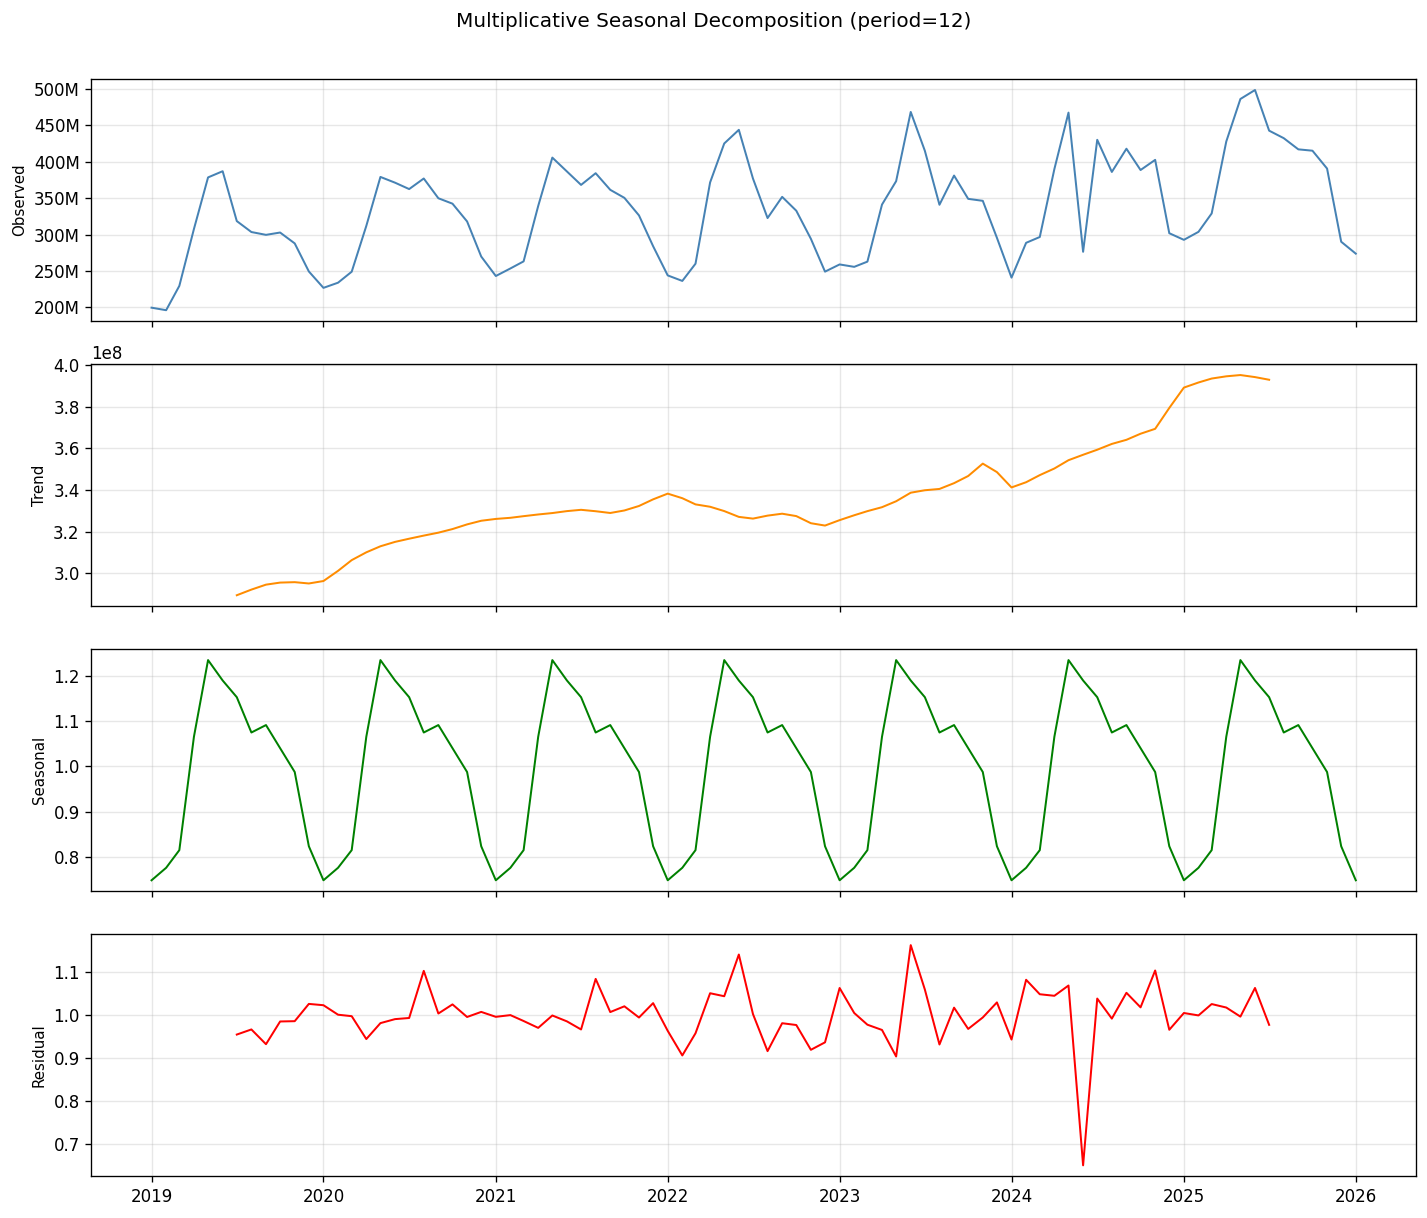

Plot saved: 03_decomposition.png


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df["total_units_kwh"], model="multiplicative", period=SEASONAL_PERIOD)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
components = [
    (decomp.observed,  "Observed",   "steelblue"),
    (decomp.trend,     "Trend",      "darkorange"),
    (decomp.seasonal,  "Seasonal",   "green"),
    (decomp.resid,     "Residual",   "red"),
]
for ax, (comp, title, color) in zip(axes, components):
    ax.plot(comp.index, comp, color=color, linewidth=1.2)
    ax.set_ylabel(title, fontsize=9)
    ax.grid(alpha=0.3)

axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
plt.suptitle("Multiplicative Seasonal Decomposition (period=12)", y=1.01, fontsize=12)
plt.tight_layout()
plt.savefig("03_decomposition.png", bbox_inches="tight")
plt.show()
print("Plot saved: 03_decomposition.png")


## 6. Stationarity Check (ADF Test)

In [7]:
def run_adf(series: pd.Series, label: str) -> dict:
    result = adfuller(series.dropna(), autolag="AIC")
    summary = {
        "label": label,
        "adf_statistic": round(result[0], 4),
        "p_value": round(result[1], 4),
        "n_lags": result[2],
        "is_stationary": result[1] < 0.05,
    }
    print(f"[{label}]  ADF={summary['adf_statistic']:.4f}  p={summary['p_value']:.4f}  "
          f"Stationary={summary['is_stationary']}")
    return summary

adf_raw     = run_adf(df["total_units_kwh"],                           "Raw Series")
adf_diff1   = run_adf(df["total_units_kwh"].diff(1),                   "1st Difference")
adf_diff12  = run_adf(df["total_units_kwh"].diff(12),                  "Seasonal Diff (lag-12)")
adf_diff1_12 = run_adf(df["total_units_kwh"].diff(1).diff(12),         "1st + Seasonal Diff")


[Raw Series]  ADF=0.1050  p=0.9664  Stationary=False
[1st Difference]  ADF=-7.3903  p=0.0000  Stationary=True
[Seasonal Diff (lag-12)]  ADF=-2.0682  p=0.2575  Stationary=False
[1st + Seasonal Diff]  ADF=-2.8875  p=0.0468  Stationary=True


## 7. ACF & PACF Plots

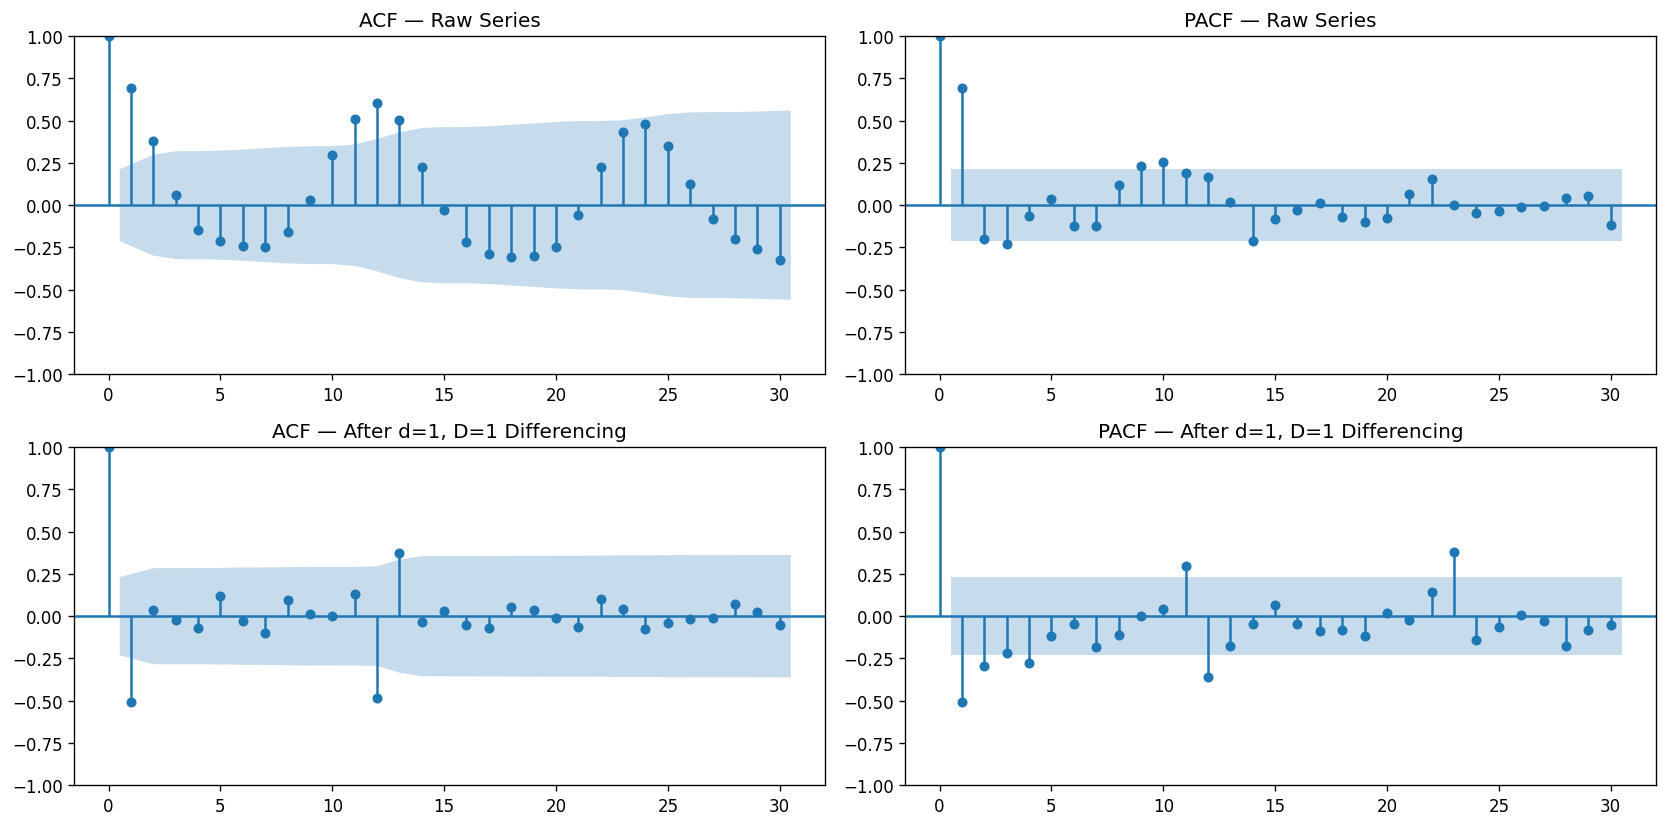

Plot saved: 04_acf_pacf.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 7))

plot_acf( df["total_units_kwh"],              lags=30, ax=axes[0][0], title="ACF — Raw Series")
plot_pacf(df["total_units_kwh"],              lags=30, ax=axes[0][1], title="PACF — Raw Series")
plot_acf( df["total_units_kwh"].diff(1).diff(12).dropna(),
          lags=30, ax=axes[1][0], title="ACF — After d=1, D=1 Differencing")
plot_pacf(df["total_units_kwh"].diff(1).diff(12).dropna(),
          lags=30, ax=axes[1][1], title="PACF — After d=1, D=1 Differencing")

plt.tight_layout()
plt.savefig("04_acf_pacf.png", bbox_inches="tight")
plt.show()
print("Plot saved: 04_acf_pacf.png")


## 8. Shared Utilities

In [9]:
def compute_metrics(actual: np.ndarray, predicted: np.ndarray) -> dict:
    """Compute MAE, RMSE, MAPE for a forecast vs actuals array."""
    actual    = np.array(actual, dtype=float)
    predicted = np.array(predicted, dtype=float)
    mae   = mean_absolute_error(actual, predicted)
    rmse  = np.sqrt(mean_squared_error(actual, predicted))
    mape  = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {"MAE": round(mae, 2), "RMSE": round(rmse, 2), "MAPE": round(mape, 4)}


def plot_forecast(train, test, forecast_values, model_name: str, save_path: str):
    """Plot train, test actuals, and model forecast on one axes."""
    fig, ax = plt.subplots(figsize=(13, 4))
    ax.plot(train.index, train, label="Train", color="steelblue",   linewidth=1.2)
    ax.plot(test.index,  test,  label="Test Actual", color="black", linewidth=1.5, linestyle="--")
    ax.plot(test.index,  forecast_values, label=f"{model_name} Forecast",
            color="tomato", linewidth=1.5, marker="o", markersize=4)
    ax.set_title(f"{model_name} — Forecast vs Actual (Test Set)")
    ax.set_ylabel("KWh")
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()


def plot_residuals(residuals: pd.Series, model_name: str, save_path: str):
    """Residual plot + ACF of residuals side by side."""
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    axes[0].plot(residuals.index, residuals, color="purple", linewidth=1)
    axes[0].axhline(0, linestyle="--", color="black", linewidth=0.8)
    axes[0].set_title(f"{model_name} — Residuals")
    axes[0].grid(alpha=0.3)
    plot_acf(residuals.dropna(), lags=20, ax=axes[1], title=f"{model_name} — Residual ACF")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()


def ljung_box_test(residuals: pd.Series, lags: int = 10) -> dict:
    """Return Ljung-Box p-value for white-noise check on residuals."""
    lb = acorr_ljungbox(residuals.dropna(), lags=[lags], return_df=True)
    return {"lb_stat": round(lb["lb_stat"].values[0], 4),
            "lb_pvalue": round(lb["lb_pvalue"].values[0], 4)}


def save_model_artifact(model, filename: str) -> str:
    """Pickle model to a temp file and return the path."""
    path = os.path.join(tempfile.gettempdir(), filename)
    with open(path, "wb") as f:
        pickle.dump(model, f)
    return path


# ── Train / Test Split ────────────────────────────────────────────────────────
# Hold out last 4 months (Oct 2025 – Jan 2026) as test set
TRAIN_END = "2025-09-01"
train = df.loc[:TRAIN_END, "total_units_kwh"]
test  = df.loc["2025-10-01":, "total_units_kwh"]

print(f"Train: {train.index[0].date()} → {train.index[-1].date()}  ({len(train)} obs)")
print(f"Test : {test.index[0].date()}  → {test.index[-1].date()}   ({len(test)} obs)")


Train: 2019-01-01 → 2025-09-01  (81 obs)
Test : 2025-10-01  → 2026-01-01   (4 obs)


## 9. MLflow Experiment Setup

In [10]:
EXP_SMOOTHING = "exponential_smoothing"
EXP_ARIMA     = "arima_sarima"

mlflow.create_experiment(EXP_SMOOTHING) if not mlflow.get_experiment_by_name(EXP_SMOOTHING) else None
mlflow.create_experiment(EXP_ARIMA)     if not mlflow.get_experiment_by_name(EXP_ARIMA)     else None

print(f"Experiment '{EXP_SMOOTHING}' ready.")
print(f"Experiment '{EXP_ARIMA}' ready.")


Experiment 'exponential_smoothing' ready.
Experiment 'arima_sarima' ready.


## 10. Stage 1 — Baseline Models
Two benchmarks every subsequent model must beat:
- **Mean Forecast**: predict the training mean for all test periods
- **Drift Forecast**: extend the line between first and last training point


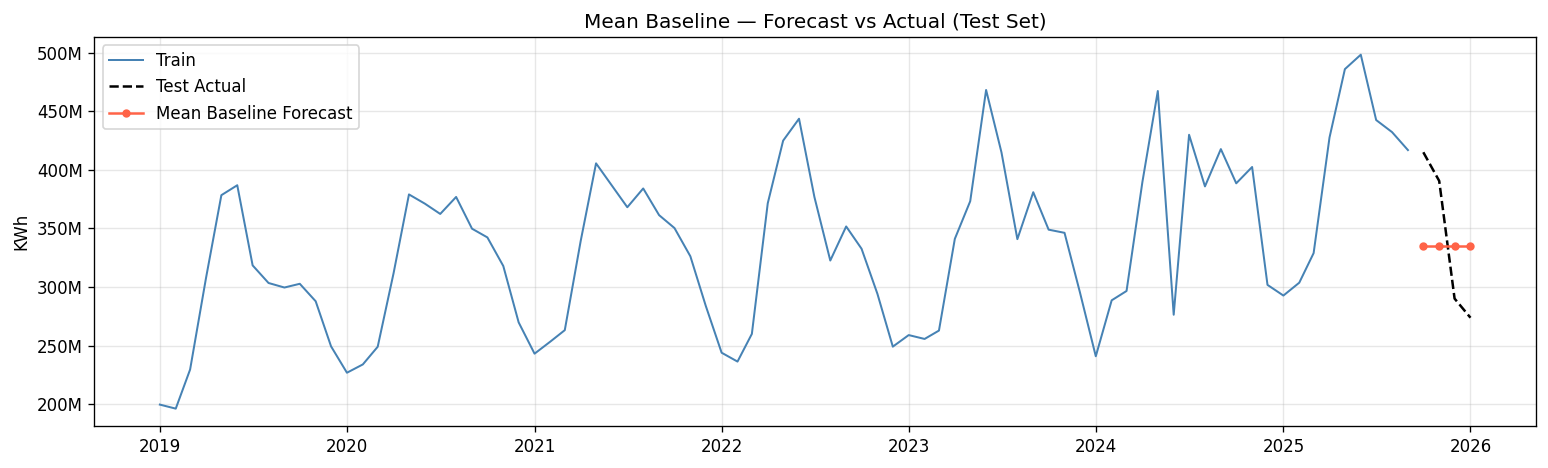

Mean Baseline → {'MAE': 60367364.5, 'RMSE': np.float64(61710893.23), 'MAPE': np.float64(17.8132)}


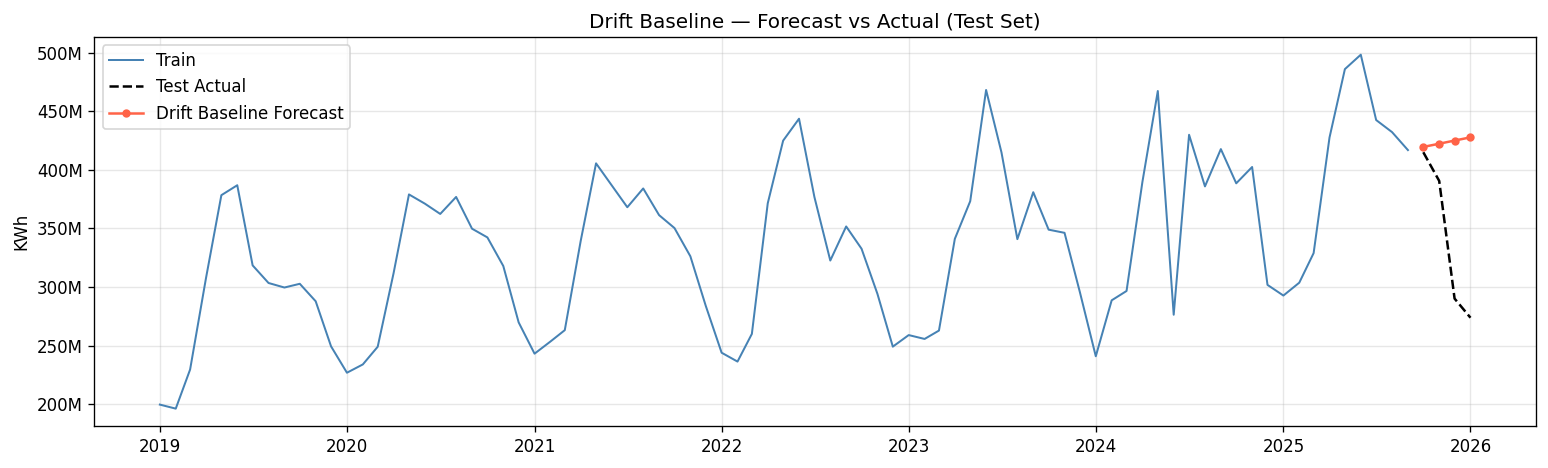

Drift Baseline → {'MAE': 81228050.25, 'RMSE': np.float64(103511884.68), 'MAPE': np.float64(27.9657)}


In [11]:
mlflow.set_experiment(EXP_SMOOTHING)

# ── Mean Baseline ─────────────────────────────────────────────────────────────
with mlflow.start_run(run_name="baseline_mean"):
    forecast_mean = np.full(len(test), train.mean())
    metrics = compute_metrics(test.values, forecast_mean)

    mlflow.set_tag("model_family", "baseline")
    mlflow.set_tag("model_variant", "mean")
    mlflow.set_tag("outlier_fixed", "True")
    mlflow.log_params({"model_type": "mean_forecast", "forecast_horizon": FORECAST_HORIZON})
    mlflow.log_metrics(metrics)

    plot_forecast(train, test, forecast_mean, "Mean Baseline", "05a_baseline_mean.png")
    mlflow.log_artifact("05a_baseline_mean.png")
    print("Mean Baseline →", metrics)

# ── Drift Baseline ────────────────────────────────────────────────────────────
with mlflow.start_run(run_name="baseline_drift"):
    n = len(train)
    drift_slope = (train.iloc[-1] - train.iloc[0]) / (n - 1)
    forecast_drift = [train.iloc[-1] + drift_slope * h for h in range(1, len(test) + 1)]
    metrics = compute_metrics(test.values, forecast_drift)

    mlflow.set_tag("model_family", "baseline")
    mlflow.set_tag("model_variant", "drift")
    mlflow.set_tag("outlier_fixed", "True")
    mlflow.log_params({"model_type": "drift_forecast", "forecast_horizon": FORECAST_HORIZON})
    mlflow.log_metrics(metrics)

    plot_forecast(train, test, forecast_drift, "Drift Baseline", "05b_baseline_drift.png")
    mlflow.log_artifact("05b_baseline_drift.png")
    print("Drift Baseline →", metrics)


## 11. Stage 2 — Simple Exponential Smoothing (SES)
Models level only (no trend, no seasonality). Expected to underfit — included for completeness.


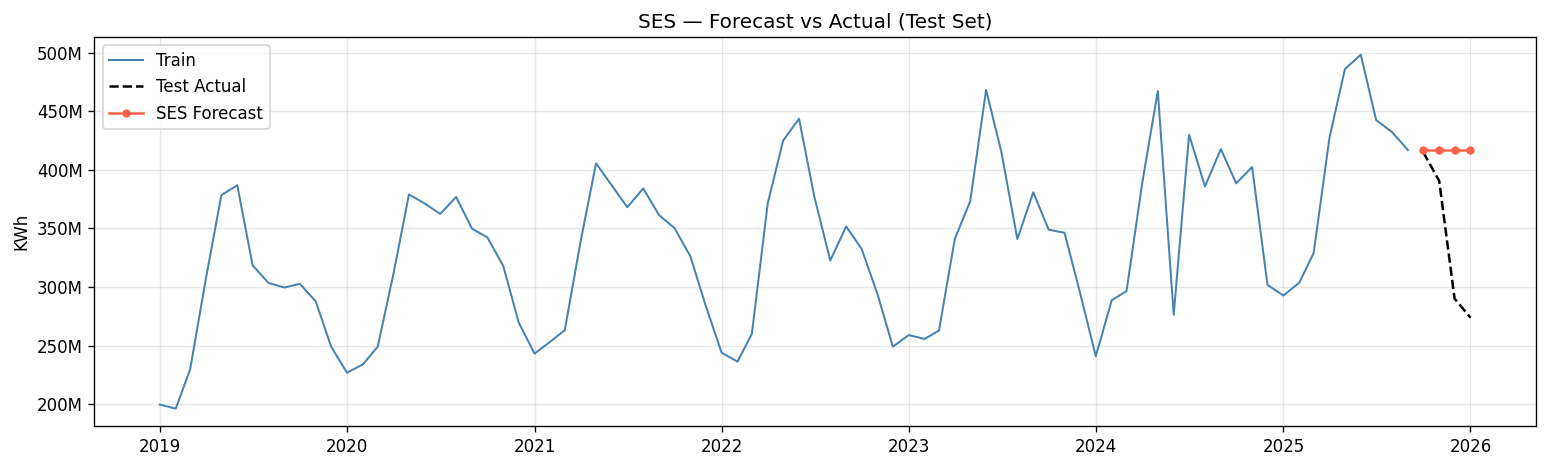

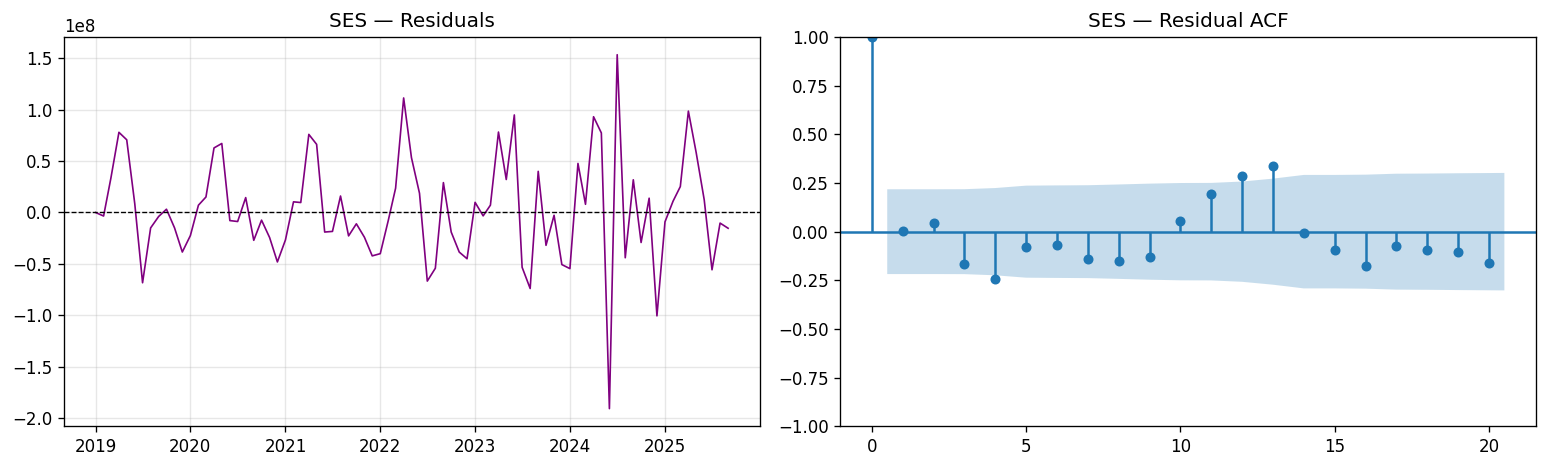

SES (α=1.0) → Metrics: {'MAE': 74444779.23, 'RMSE': np.float64(96406890.82), 'MAPE': np.float64(25.7625)} | Ljung-Box: {'lb_stat': np.float64(14.3822), 'lb_pvalue': np.float64(0.1563)}


In [12]:
mlflow.set_experiment(EXP_SMOOTHING)

with mlflow.start_run(run_name="SES"):
    model_ses = SimpleExpSmoothing(train, initialization_method="estimated").fit(optimized=True)
    forecast_ses = model_ses.forecast(len(test))
    metrics = compute_metrics(test.values, forecast_ses.values)

    alpha = round(model_ses.params["smoothing_level"], 4)

    mlflow.set_tag("model_family", "exponential_smoothing")
    mlflow.set_tag("model_variant", "SES")
    mlflow.set_tag("outlier_fixed", "True")
    mlflow.log_params({
        "model_type": "SimpleExpSmoothing",
        "alpha": alpha,
        "forecast_horizon": FORECAST_HORIZON,
    })
    mlflow.log_metrics(metrics)

    plot_forecast(train, test, forecast_ses, "SES", "06_ses_forecast.png")
    mlflow.log_artifact("06_ses_forecast.png")

    residuals = pd.Series(model_ses.resid, index=train.index)
    plot_residuals(residuals, "SES", "06_ses_residuals.png")
    mlflow.log_artifact("06_ses_residuals.png")

    lb = ljung_box_test(residuals)
    mlflow.log_metrics(lb)

    model_path = save_model_artifact(model_ses, "ses_model.pkl")
    mlflow.log_artifact(model_path, artifact_path="model")

    print(f"SES (α={alpha}) → Metrics: {metrics} | Ljung-Box: {lb}")


## 12. Stage 3 — Holt's Linear Exponential Smoothing (Double ES)
Adds trend component (α + β). Two variants: standard and damped trend.


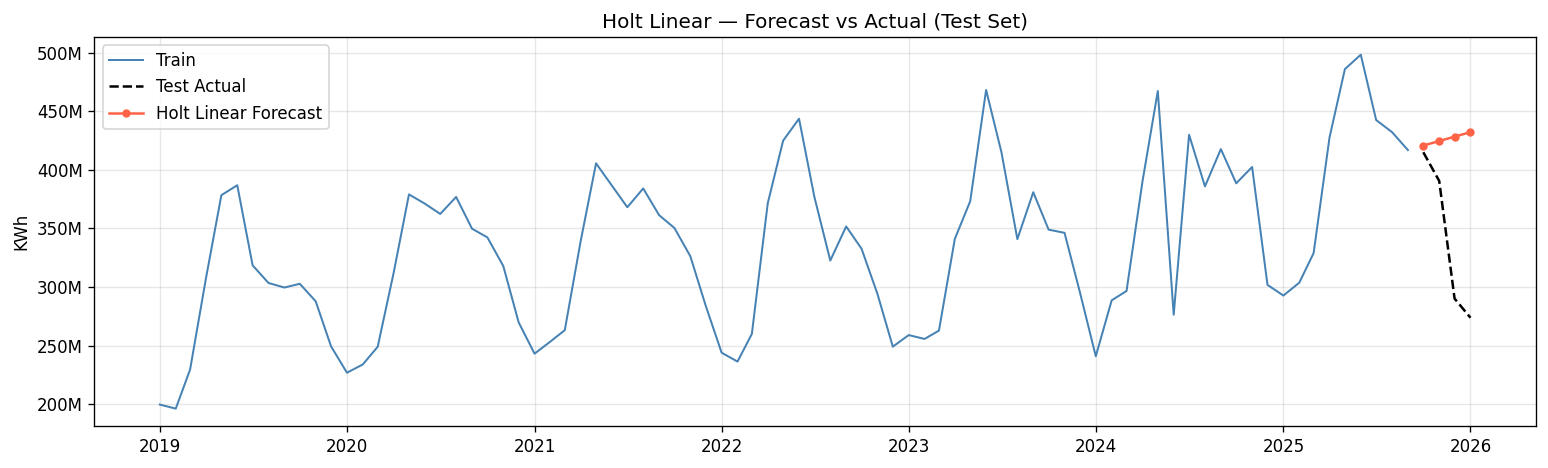

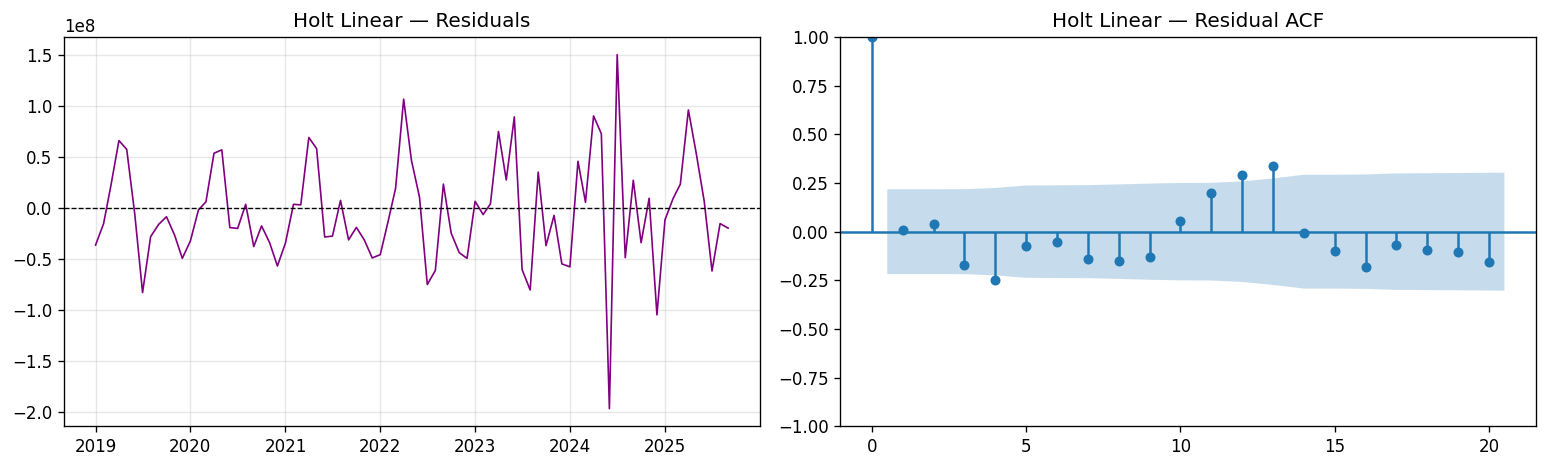

Holt Linear (α=0.995, β=0.0237, φ=nan) → {'MAE': 84027608.75, 'RMSE': np.float64(106431240.91), 'MAPE': np.float64(28.8728)} | AIC=2888.65


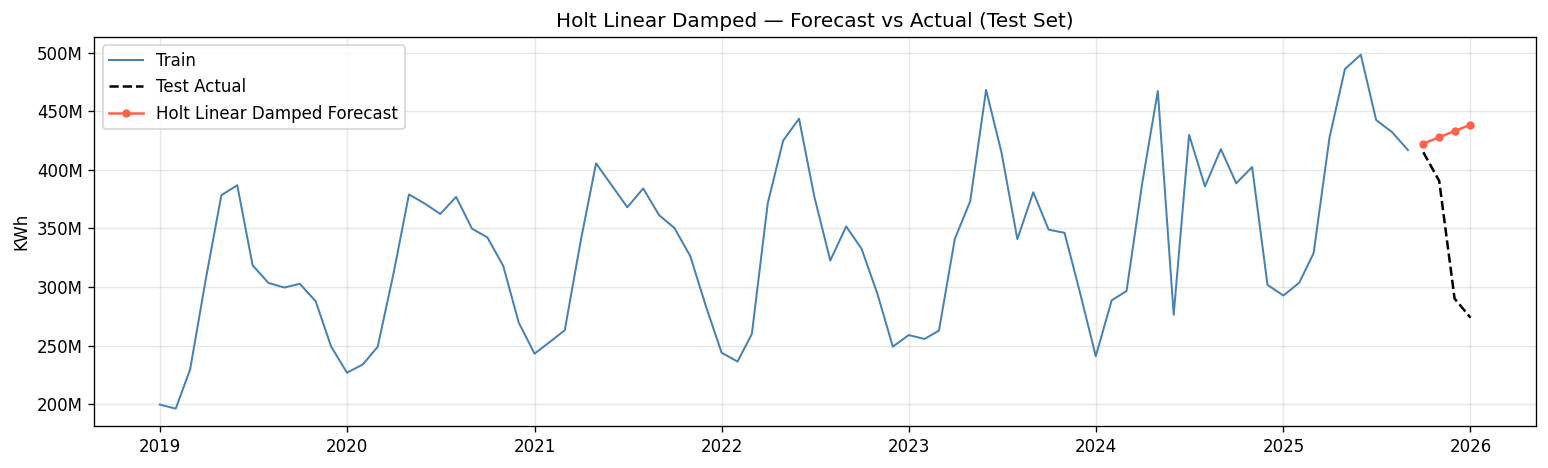

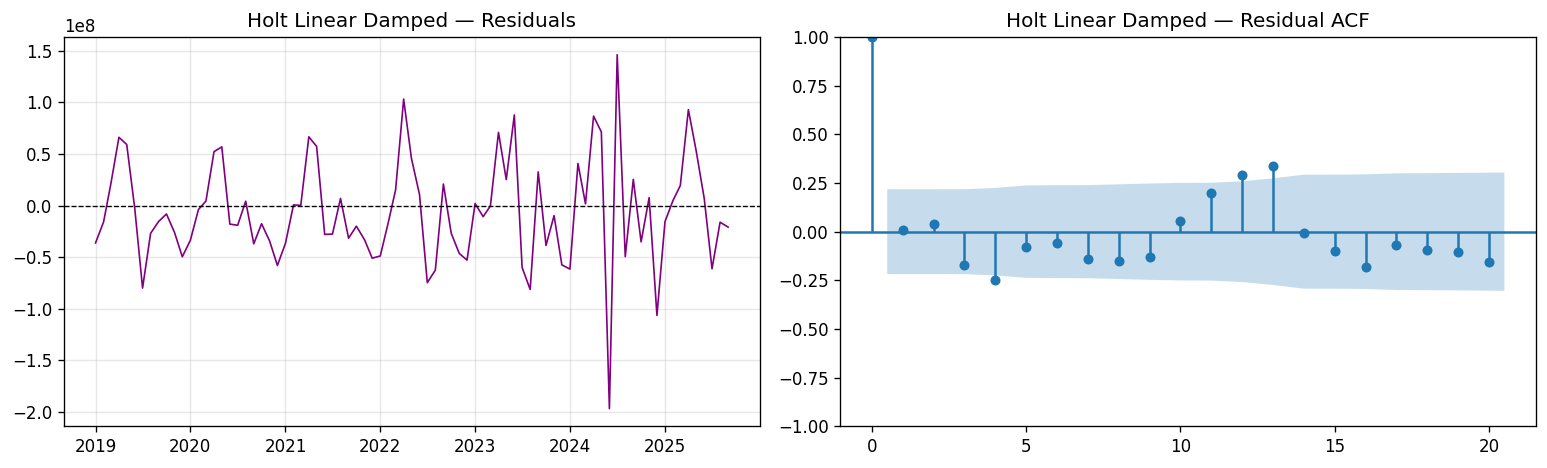

Holt Linear Damped (α=0.995, β=0.0001, φ=0.99) → {'MAE': 88028159.19, 'RMSE': np.float64(110615404.68), 'MAPE': np.float64(30.1688)} | AIC=2889.24


In [13]:
mlflow.set_experiment(EXP_SMOOTHING)

holt_variants = [
    {"damped_trend": False, "run_name": "Holts_Linear",       "label": "Holt Linear"},
    {"damped_trend": True,  "run_name": "Holts_Linear_Damped","label": "Holt Linear Damped"},
]

for variant in holt_variants:
    with mlflow.start_run(run_name=variant["run_name"]):
        model_holt = ExponentialSmoothing(
            train,
            trend="add",
            damped_trend=variant["damped_trend"],
            initialization_method="estimated",
        ).fit(optimized=True)

        forecast_holt = model_holt.forecast(len(test))
        metrics = compute_metrics(test.values, forecast_holt.values)

        alpha = round(model_holt.params["smoothing_level"], 4)
        beta  = round(model_holt.params["smoothing_trend"], 4)
        phi   = round(model_holt.params.get("damping_trend", 1.0), 4)

        mlflow.set_tag("model_family", "exponential_smoothing")
        mlflow.set_tag("model_variant", variant["run_name"])
        mlflow.set_tag("outlier_fixed", "True")
        mlflow.log_params({
            "model_type": "Holts_ExponentialSmoothing",
            "trend": "additive",
            "damped_trend": variant["damped_trend"],
            "alpha": alpha,
            "beta": beta,
            "phi": phi,
            "forecast_horizon": FORECAST_HORIZON,
        })
        mlflow.log_metrics(metrics)

        plot_forecast(train, test, forecast_holt, variant["label"],
                      f"07_{variant['run_name']}_forecast.png")
        mlflow.log_artifact(f"07_{variant['run_name']}_forecast.png")

        residuals = pd.Series(model_holt.resid, index=train.index)
        plot_residuals(residuals, variant["label"], f"07_{variant['run_name']}_residuals.png")
        mlflow.log_artifact(f"07_{variant['run_name']}_residuals.png")

        lb = ljung_box_test(residuals)
        mlflow.log_metrics(lb)
        mlflow.log_metric("AIC", round(model_holt.aic, 4))

        model_path = save_model_artifact(model_holt, f"{variant['run_name']}.pkl")
        mlflow.log_artifact(model_path, artifact_path="model")

        print(f"{variant['label']} (α={alpha}, β={beta}, φ={phi}) → {metrics} | AIC={model_holt.aic:.2f}")


## 13. Stage 4 — Holt-Winters Exponential Smoothing
Adds seasonal component (α + β + γ). Four variants covering additive/multiplicative
seasonal and standard/damped trend combinations.


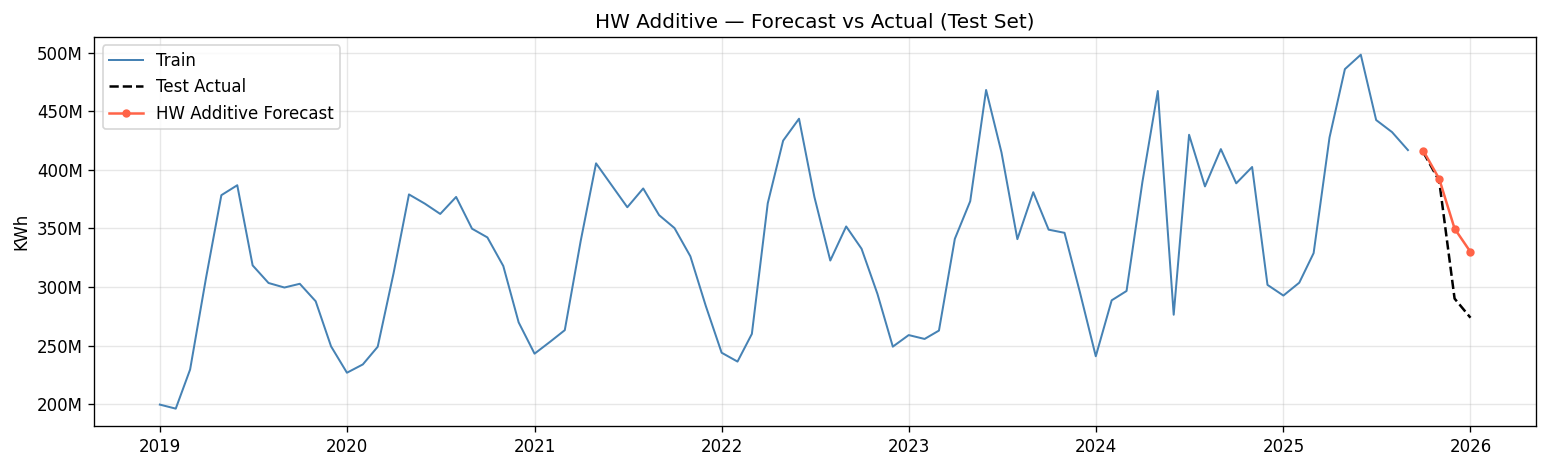

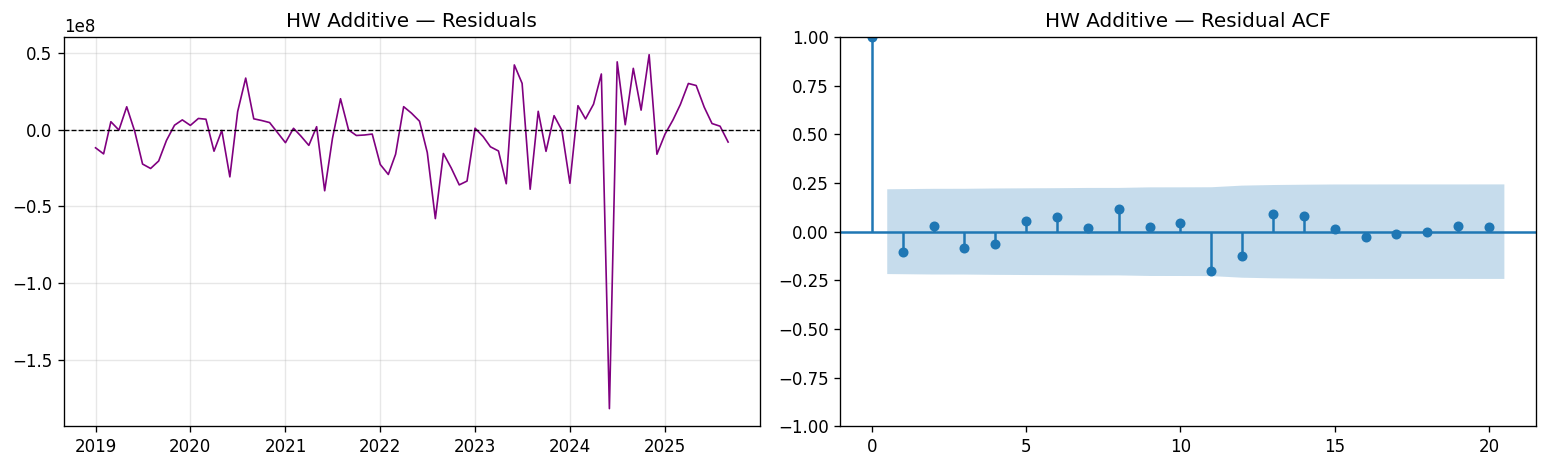

HW Additive (α=0.1399, β=0.0038, γ=0.0, φ=nan) → {'MAE': 29717938.07, 'RMSE': np.float64(40980720.57), 'MAPE': np.float64(10.4585)} | AIC=2814.49


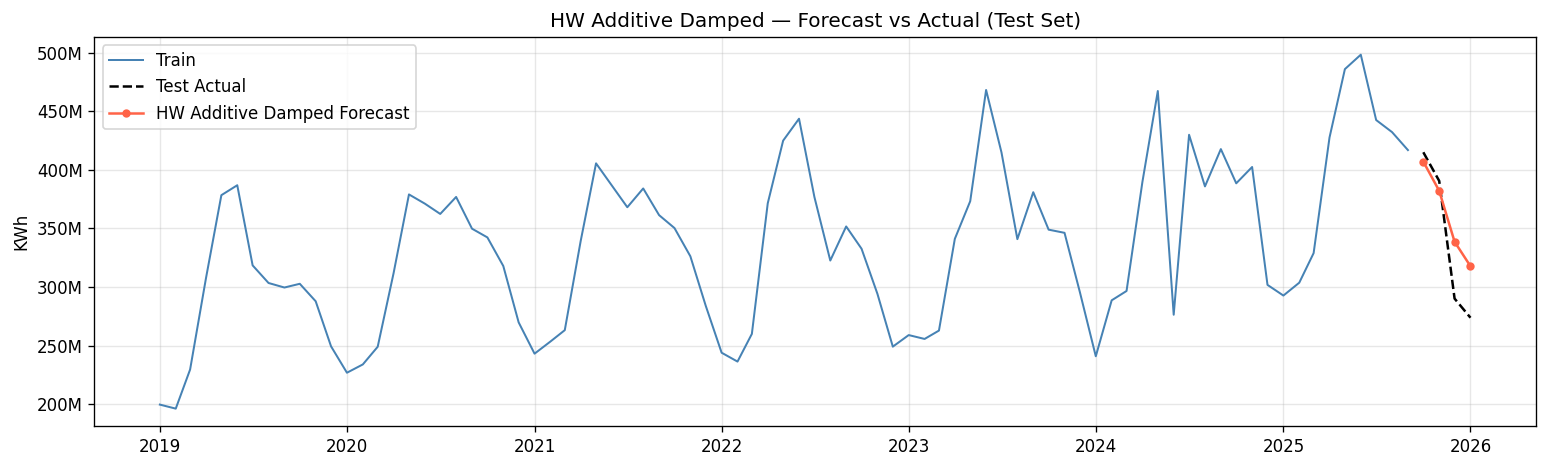

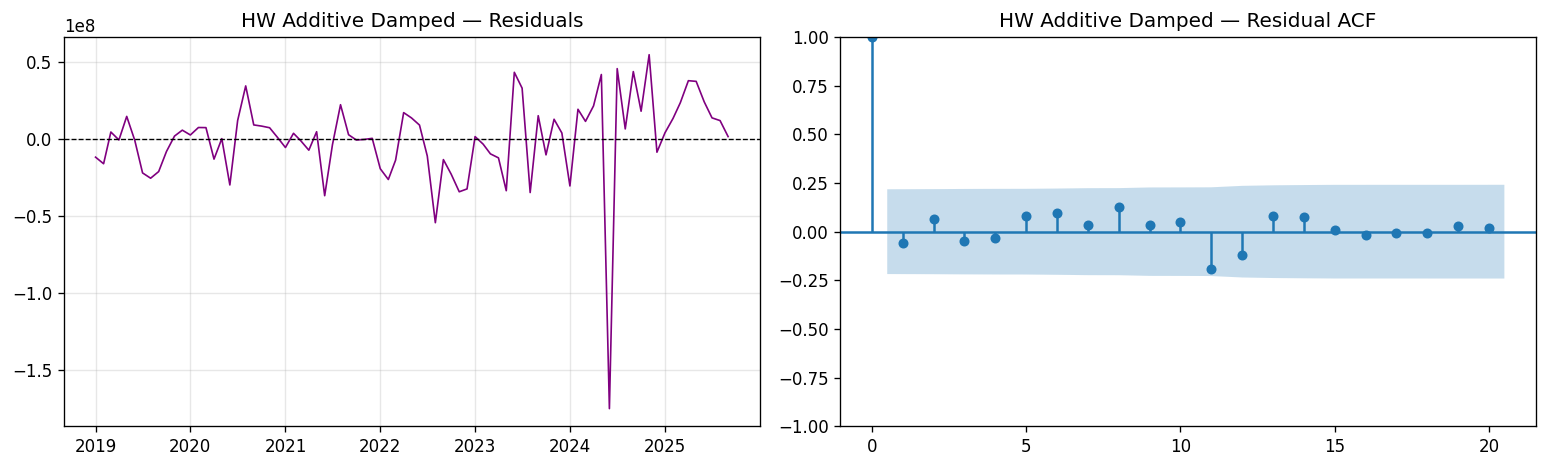

HW Additive Damped (α=0.1111, β=0.0001, γ=0.0001, φ=0.99) → {'MAE': 27219741.51, 'RMSE': np.float64(33232852.59), 'MAPE': np.float64(9.2131)} | AIC=2816.52


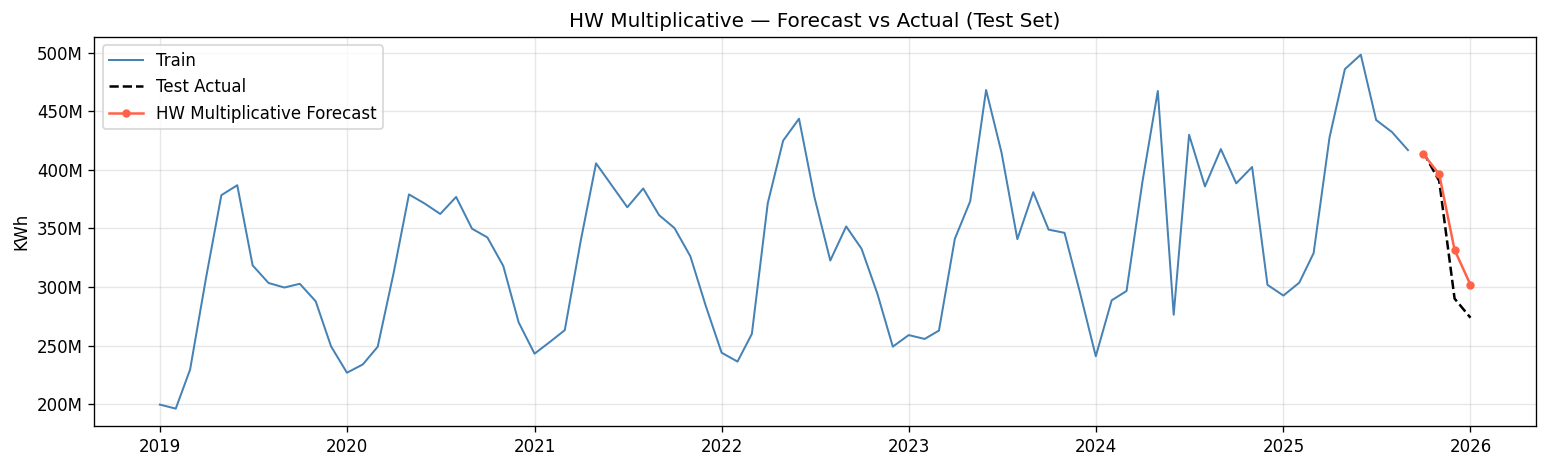

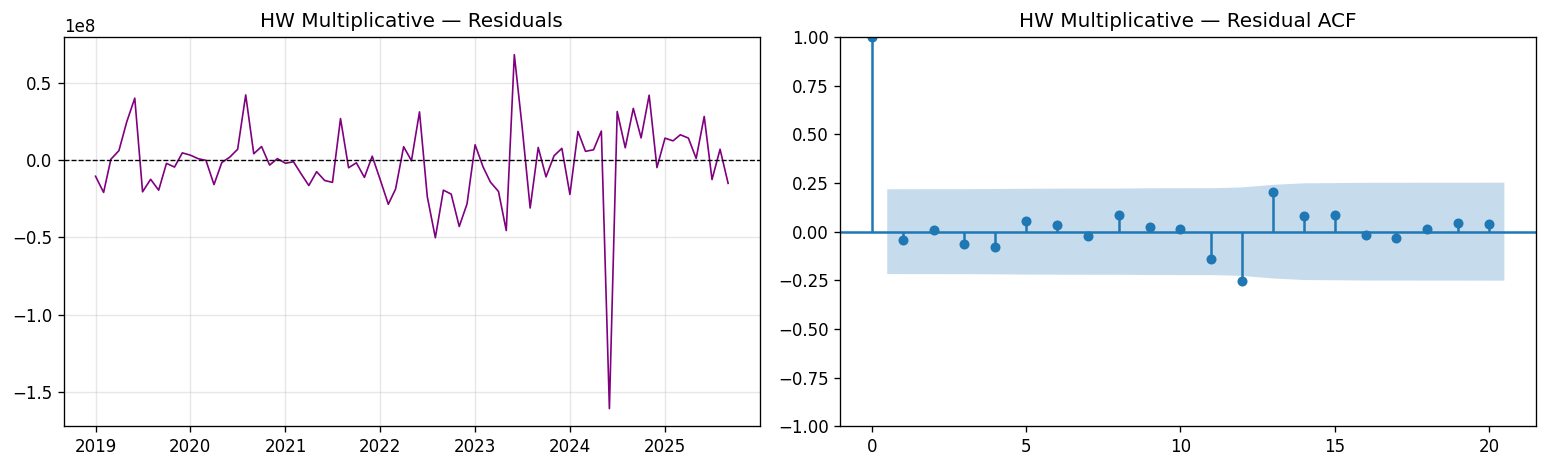

HW Multiplicative (α=0.1388, β=0.005, γ=0.0, φ=nan) → {'MAE': 19180283.43, 'RMSE': np.float64(25237369.89), 'MAPE': np.float64(6.5918)} | AIC=2804.14


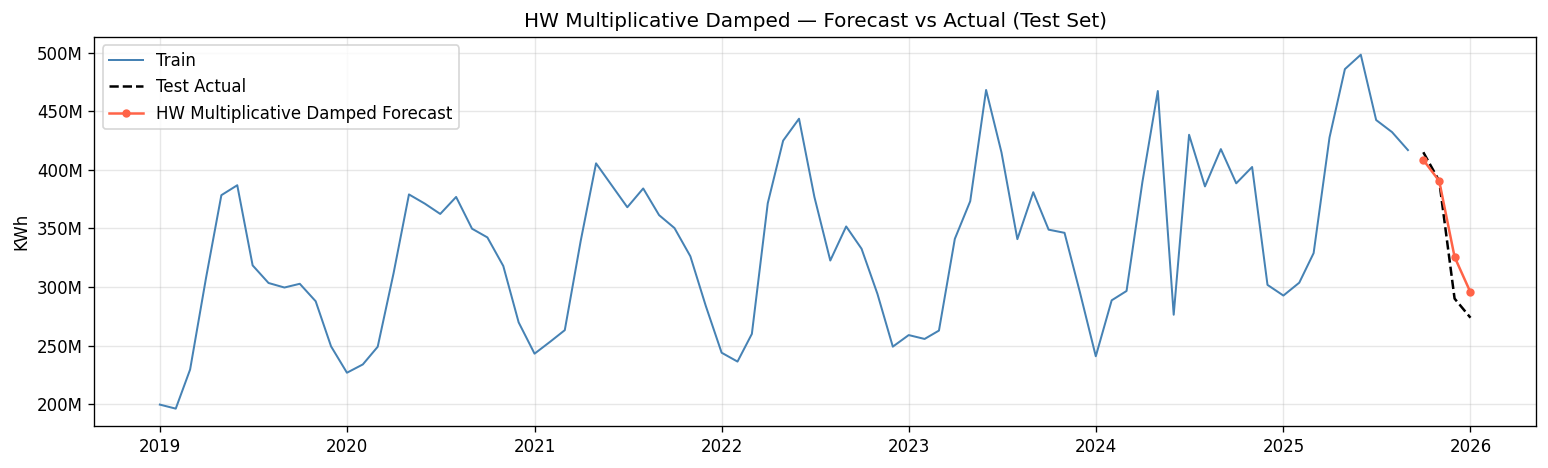

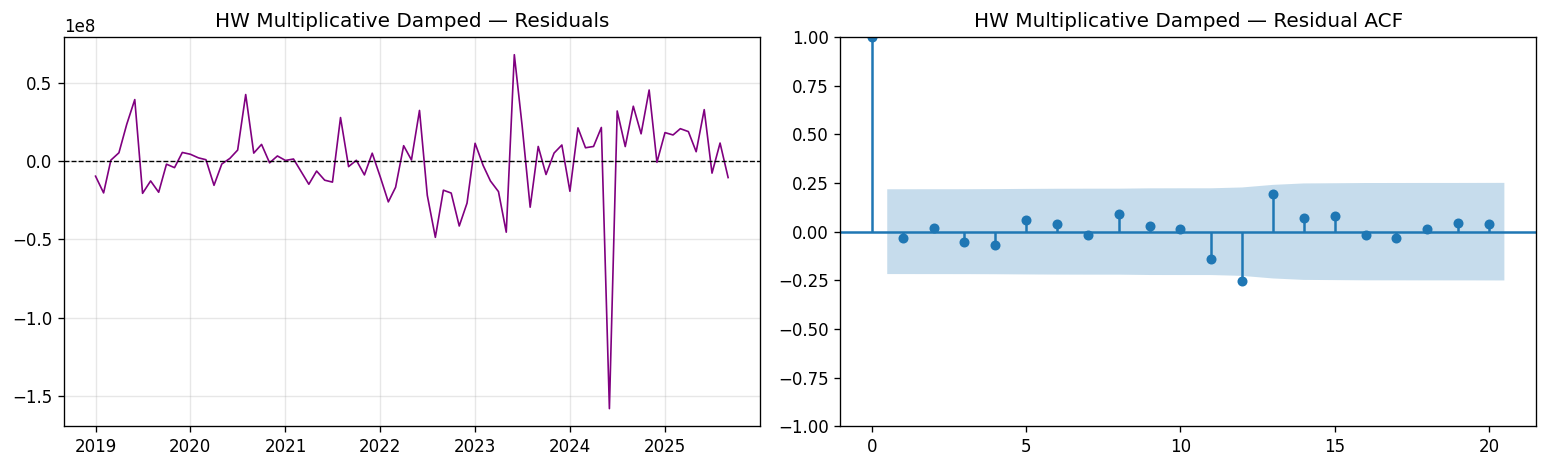

HW Multiplicative Damped (α=0.1242, β=0.0, γ=0.0, φ=0.9938) → {'MAE': 15960064.34, 'RMSE': np.float64(21069970.19), 'MAPE': np.float64(5.4403)} | AIC=2805.38


In [14]:
mlflow.set_experiment(EXP_SMOOTHING)

hw_variants = [
    {"seasonal": "add", "damped_trend": False, "run_name": "HW_Additive",
     "label": "HW Additive"},
    {"seasonal": "add", "damped_trend": True,  "run_name": "HW_Additive_Damped",
     "label": "HW Additive Damped"},
    {"seasonal": "mul", "damped_trend": False, "run_name": "HW_Multiplicative",
     "label": "HW Multiplicative"},
    {"seasonal": "mul", "damped_trend": True,  "run_name": "HW_Multiplicative_Damped",
     "label": "HW Multiplicative Damped"},
]

for variant in hw_variants:
    with mlflow.start_run(run_name=variant["run_name"]):
        model_hw = ExponentialSmoothing(
            train,
            trend="add",
            damped_trend=variant["damped_trend"],
            seasonal=variant["seasonal"],
            seasonal_periods=SEASONAL_PERIOD,
            initialization_method="estimated",
        ).fit(optimized=True)

        forecast_hw = model_hw.forecast(len(test))
        metrics = compute_metrics(test.values, forecast_hw.values)

        alpha = round(model_hw.params["smoothing_level"], 4)
        beta  = round(model_hw.params["smoothing_trend"], 4)
        gamma = round(model_hw.params["smoothing_seasonal"], 4)
        phi   = round(model_hw.params.get("damping_trend", 1.0), 4)

        mlflow.set_tag("model_family", "holt_winters")
        mlflow.set_tag("model_variant", variant["run_name"])
        mlflow.set_tag("outlier_fixed", "True")
        mlflow.log_params({
            "model_type": "HoltWinters",
            "trend": "additive",
            "seasonal": variant["seasonal"],
            "seasonal_periods": SEASONAL_PERIOD,
            "damped_trend": variant["damped_trend"],
            "alpha": alpha,
            "beta": beta,
            "gamma": gamma,
            "phi": phi,
            "forecast_horizon": FORECAST_HORIZON,
        })
        mlflow.log_metrics(metrics)

        plot_forecast(train, test, forecast_hw, variant["label"],
                      f"08_{variant['run_name']}_forecast.png")
        mlflow.log_artifact(f"08_{variant['run_name']}_forecast.png")

        residuals = pd.Series(model_hw.resid, index=train.index)
        plot_residuals(residuals, variant["label"], f"08_{variant['run_name']}_residuals.png")
        mlflow.log_artifact(f"08_{variant['run_name']}_residuals.png")

        lb = ljung_box_test(residuals)
        mlflow.log_metrics(lb)
        mlflow.log_metric("AIC", round(model_hw.aic, 4))
        mlflow.log_metric("BIC", round(model_hw.bic, 4))

        model_path = save_model_artifact(model_hw, f"{variant['run_name']}.pkl")
        mlflow.log_artifact(model_path, artifact_path="model")

        print(f"{variant['label']} (α={alpha}, β={beta}, γ={gamma}, φ={phi}) "
              f"→ {metrics} | AIC={model_hw.aic:.2f}")


## 14. Stage 5 — ARIMA
Non-seasonal ARIMA using auto_arima for order selection. Acts as stepping stone to SARIMA.


Running auto_arima (non-seasonal)... this may take ~30 seconds.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3077.862, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3074.323, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3076.329, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3076.373, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3072.545, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3078.357, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.086 seconds

Best ARIMA order: (0, 1, 0)


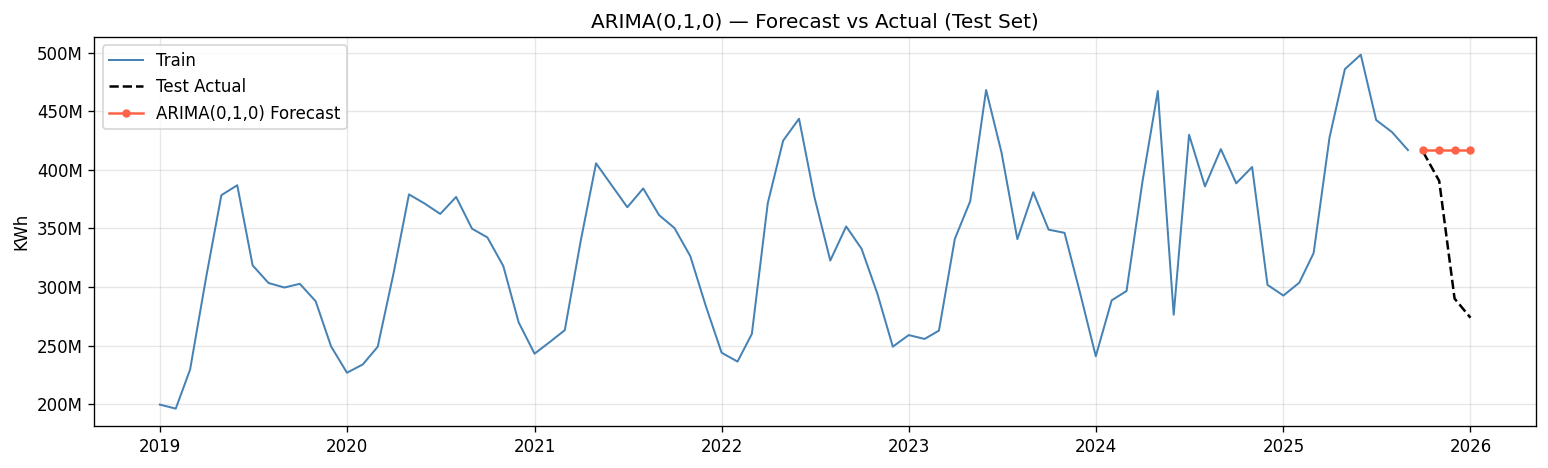

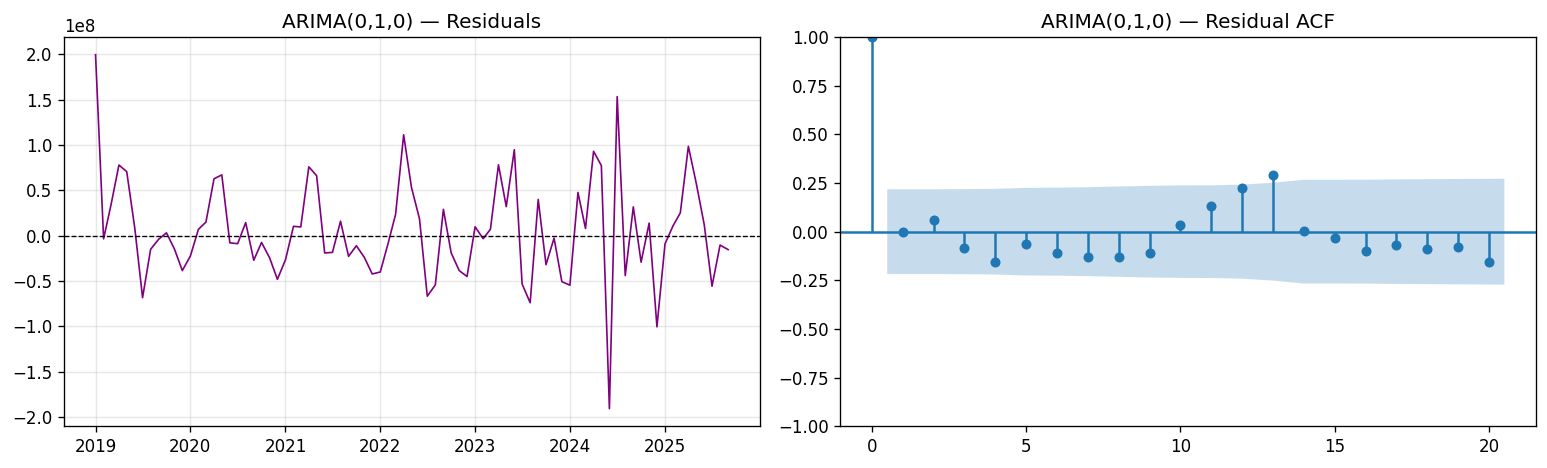

ARIMA(0,1,0) → {'MAE': 74444779.0, 'RMSE': np.float64(96406890.64), 'MAPE': np.float64(25.7625)} | AIC=3072.55


In [15]:
mlflow.set_experiment(EXP_ARIMA)

with mlflow.start_run(run_name="ARIMA_auto"):
    print("Running auto_arima (non-seasonal)... this may take ~30 seconds.")
    auto_arima_model = pm.auto_arima(
        train,
        seasonal=False,
        stepwise=True,
        information_criterion="aic",
        error_action="ignore",
        suppress_warnings=True,
        trace=True,
    )
    print("\nBest ARIMA order:", auto_arima_model.order)

    forecast_arima = auto_arima_model.predict(n_periods=len(test))
    metrics = compute_metrics(test.values, forecast_arima)

    p, d, q = auto_arima_model.order

    mlflow.set_tag("model_family", "arima")
    mlflow.set_tag("model_variant", f"ARIMA({p},{d},{q})")
    mlflow.set_tag("outlier_fixed", "True")
    mlflow.log_params({
        "model_type": "ARIMA",
        "p": p, "d": d, "q": q,
        "forecast_horizon": FORECAST_HORIZON,
        "selection_criterion": "AIC",
    })
    mlflow.log_metrics(metrics)
    mlflow.log_metric("AIC", round(auto_arima_model.aic(), 4))
    mlflow.log_metric("BIC", round(auto_arima_model.bic(), 4))

    # Build forecast series for plotting
    forecast_arima_series = pd.Series(forecast_arima, index=test.index)
    plot_forecast(train, test, forecast_arima_series, f"ARIMA({p},{d},{q})",
                  "09_arima_forecast.png")
    mlflow.log_artifact("09_arima_forecast.png")

    residuals = pd.Series(auto_arima_model.resid(), index=train.index)
    plot_residuals(residuals, f"ARIMA({p},{d},{q})", "09_arima_residuals.png")
    mlflow.log_artifact("09_arima_residuals.png")

    lb = ljung_box_test(residuals)
    mlflow.log_metrics(lb)

    model_path = save_model_artifact(auto_arima_model, "arima_model.pkl")
    mlflow.log_artifact(model_path, artifact_path="model")

    print(f"ARIMA({p},{d},{q}) → {metrics} | AIC={auto_arima_model.aic():.2f}")


## 15. Stage 6a — SARIMA (auto_arima)
Seasonal ARIMA with m=12. auto_arima searches optimal (p,d,q)(P,D,Q)[12].


Running auto_arima (seasonal, m=12)... this may take ~60 seconds.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=2630.622, Time=1.56 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2629.635, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2632.911, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2633.117, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2639.397, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=2631.273, Time=0.08 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=2631.192, Time=0.15 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=2632.068, Time=0.50 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2631.535, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=2631.657, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=2633.617, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 2.894 seconds

Best SARIMA order: (0, 0, 0) x (0, 1, 0, 12)


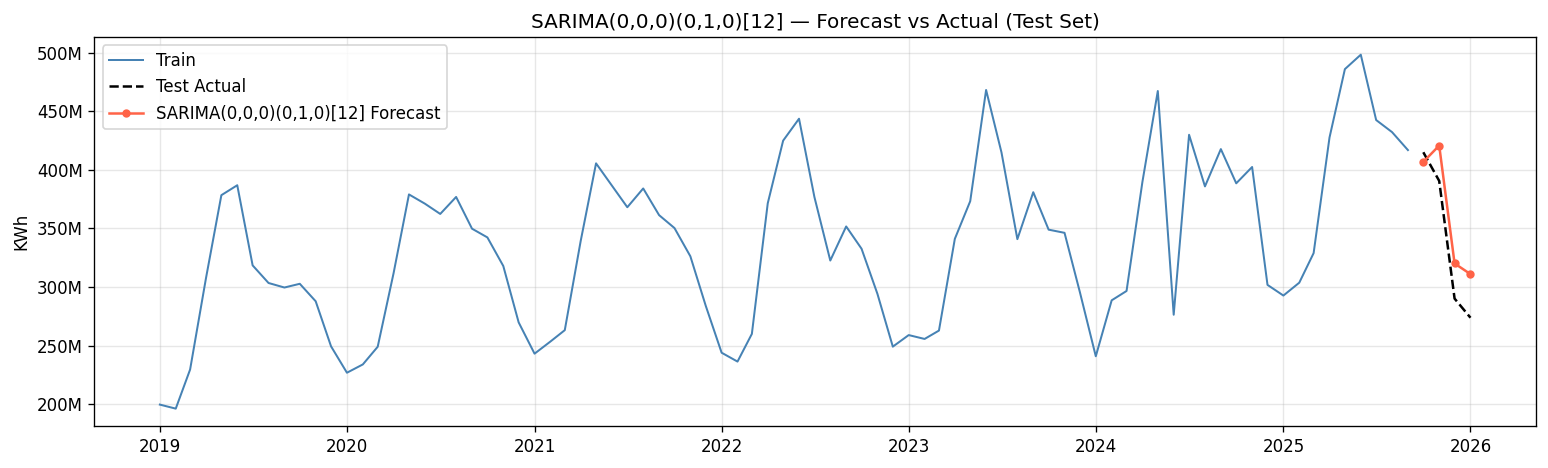

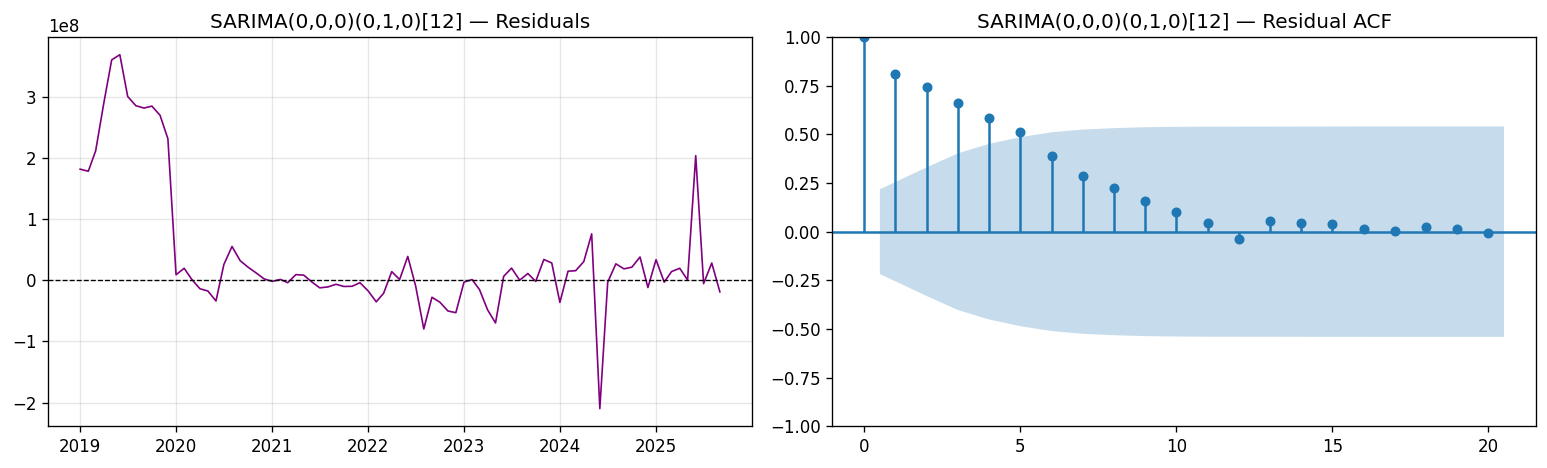

SARIMA(0,0,0)(0,1,0)[12] → {'MAE': 26380409.63, 'RMSE': np.float64(28538307.72), 'MAPE': np.float64(8.4028)} | AIC=2629.64


In [16]:
mlflow.set_experiment(EXP_ARIMA)

with mlflow.start_run(run_name="SARIMA_auto"):
    print("Running auto_arima (seasonal, m=12)... this may take ~60 seconds.")
    auto_sarima_model = pm.auto_arima(
        train,
        seasonal=True,
        m=SEASONAL_PERIOD,
        stepwise=True,
        information_criterion="aic",
        D=1,           # enforce seasonal differencing based on analysis
        max_p=3, max_q=3, max_P=2, max_Q=2,
        error_action="ignore",
        suppress_warnings=True,
        trace=True,
    )
    print("\nBest SARIMA order:", auto_sarima_model.order, "x", auto_sarima_model.seasonal_order)

    forecast_sarima_auto = auto_sarima_model.predict(n_periods=len(test))
    metrics = compute_metrics(test.values, forecast_sarima_auto)

    p, d, q = auto_sarima_model.order
    P, D, Q, m = auto_sarima_model.seasonal_order

    mlflow.set_tag("model_family", "sarima")
    mlflow.set_tag("model_variant", f"SARIMA({p},{d},{q})({P},{D},{Q})[{m}]")
    mlflow.set_tag("outlier_fixed", "True")
    mlflow.log_params({
        "model_type": "SARIMA_auto",
        "p": p, "d": d, "q": q,
        "P": P, "D": D, "Q": Q, "m": m,
        "forecast_horizon": FORECAST_HORIZON,
        "selection_criterion": "AIC",
    })
    mlflow.log_metrics(metrics)
    mlflow.log_metric("AIC", round(auto_sarima_model.aic(), 4))
    mlflow.log_metric("BIC", round(auto_sarima_model.bic(), 4))

    forecast_sarima_series = pd.Series(forecast_sarima_auto, index=test.index)
    plot_forecast(train, test, forecast_sarima_series,
                  f"SARIMA({p},{d},{q})({P},{D},{Q})[{m}]",
                  "10_sarima_auto_forecast.png")
    mlflow.log_artifact("10_sarima_auto_forecast.png")

    residuals = pd.Series(auto_sarima_model.resid(), index=train.index)
    plot_residuals(residuals, f"SARIMA({p},{d},{q})({P},{D},{Q})[{m}]",
                   "10_sarima_auto_residuals.png")
    mlflow.log_artifact("10_sarima_auto_residuals.png")

    lb = ljung_box_test(residuals)
    mlflow.log_metrics(lb)

    model_path = save_model_artifact(auto_sarima_model, "sarima_auto_model.pkl")
    mlflow.log_artifact(model_path, artifact_path="model")

    print(f"SARIMA({p},{d},{q})({P},{D},{Q})[{m}] → {metrics} | AIC={auto_sarima_model.aic():.2f}")


## 16. Stage 6b — SARIMA Manual Candidates
Manually test SARIMA(1,1,1)(1,1,1)[12] — backed by ACF/PACF analysis.
Also test (1,0,1)(1,1,1)[12] since ADF confirmed trend-stationarity.


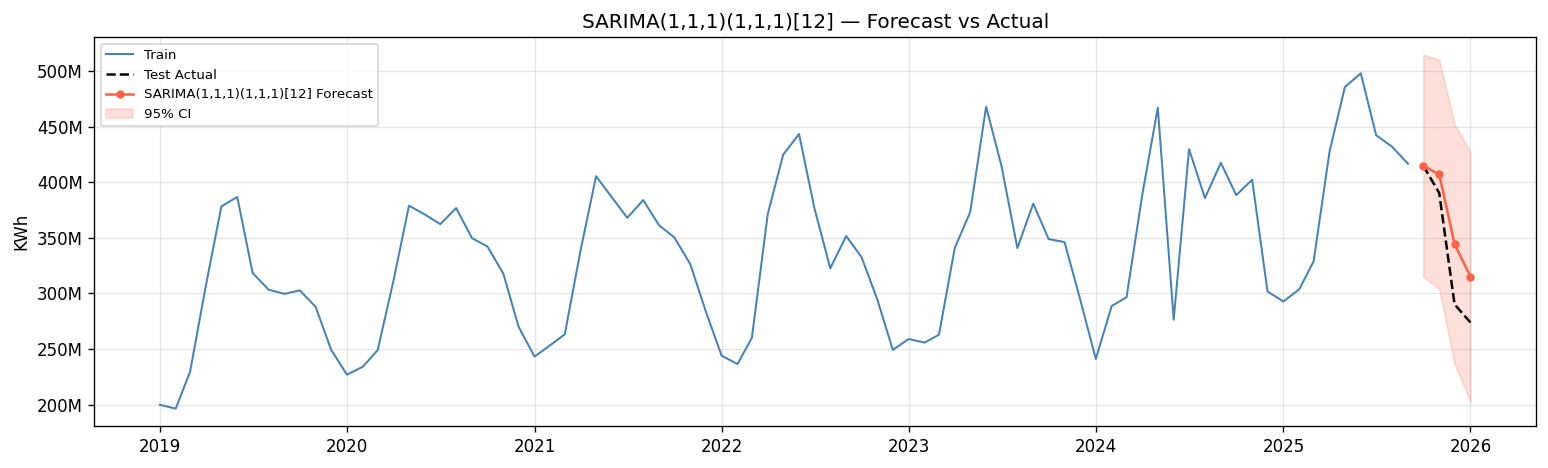

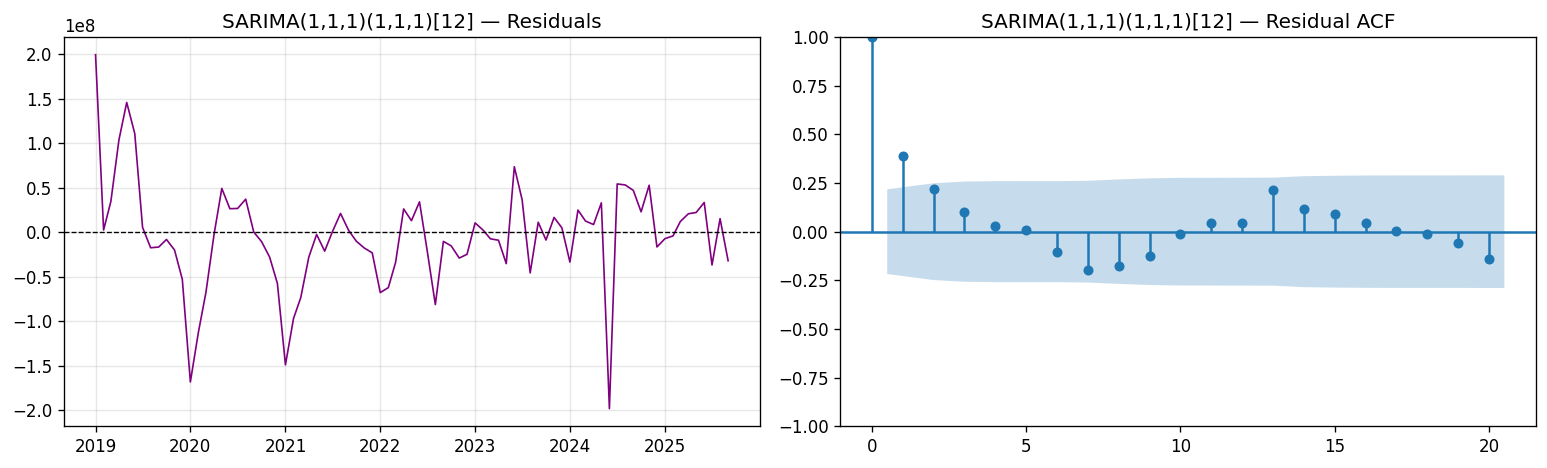

SARIMA(1,1,1)(1,1,1)[12] → {'MAE': 28068649.38, 'RMSE': np.float64(35121415.79), 'MAPE': np.float64(9.5173)} | AIC=2061.74 | Ljung-Box p=0.003


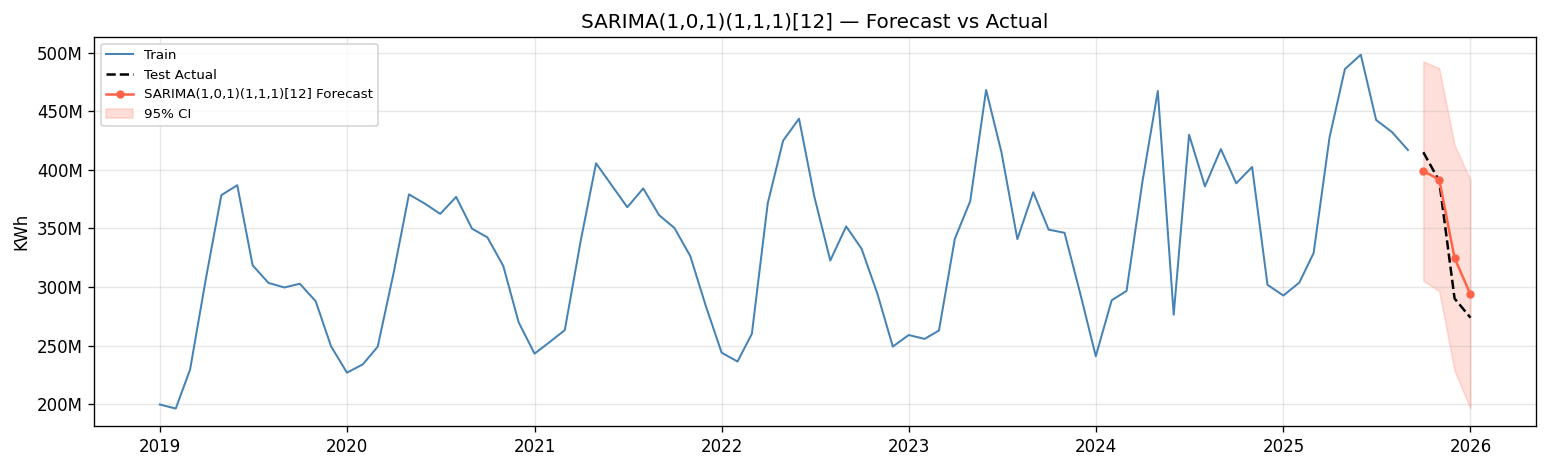

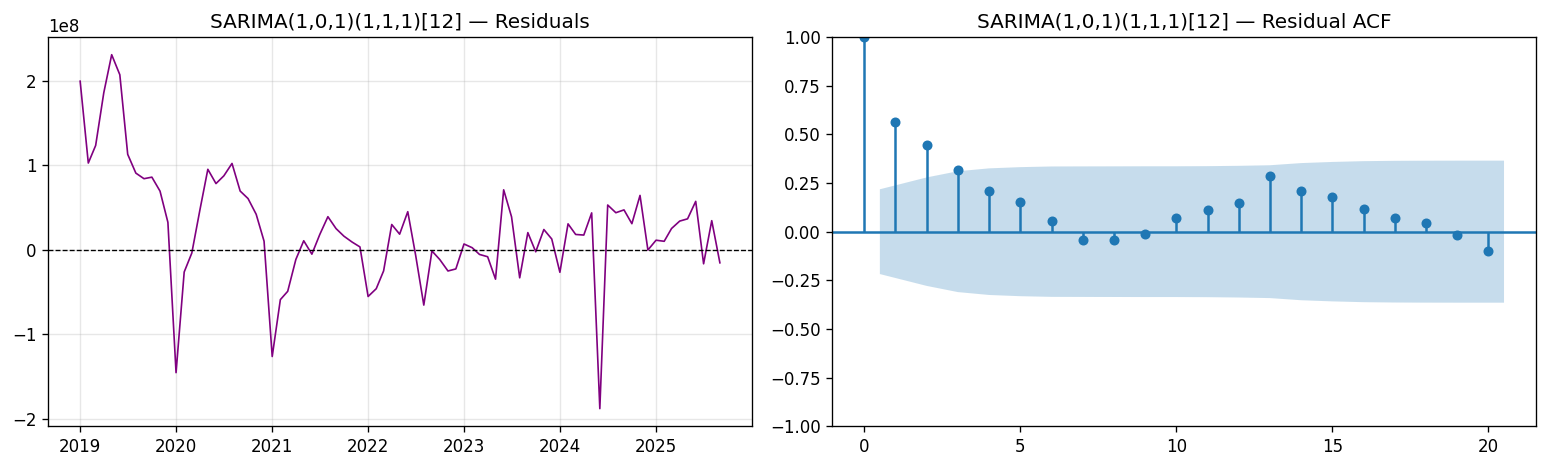

SARIMA(1,0,1)(1,1,1)[12] → {'MAE': 17885675.59, 'RMSE': np.float64(21485524.78), 'MAPE': np.float64(5.8261)} | AIC=2095.68 | Ljung-Box p=0.0


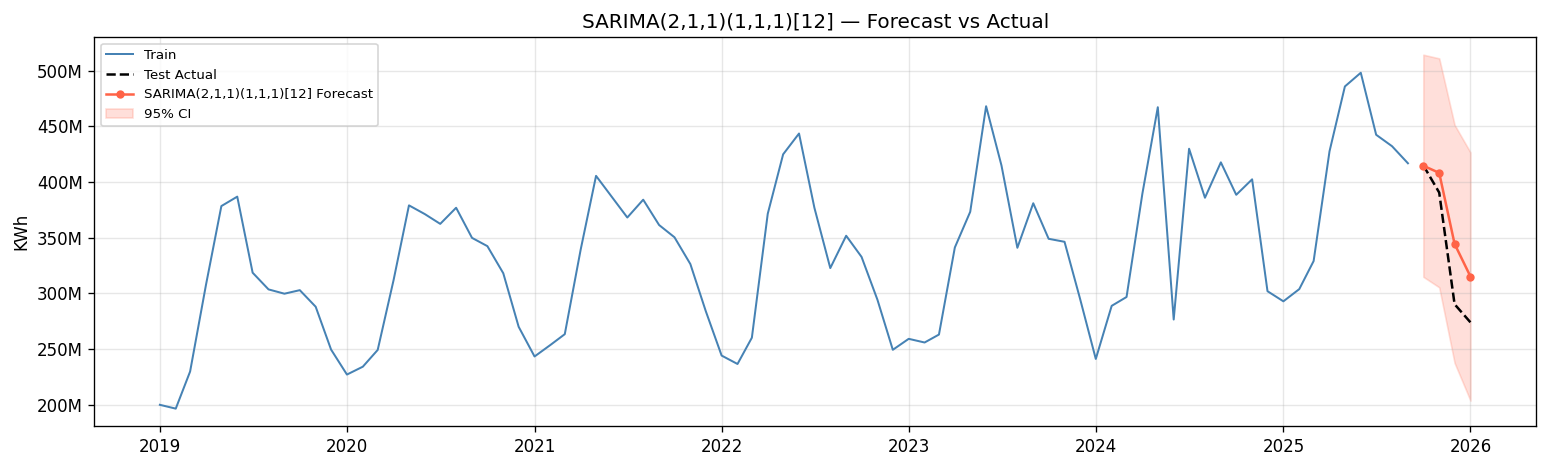

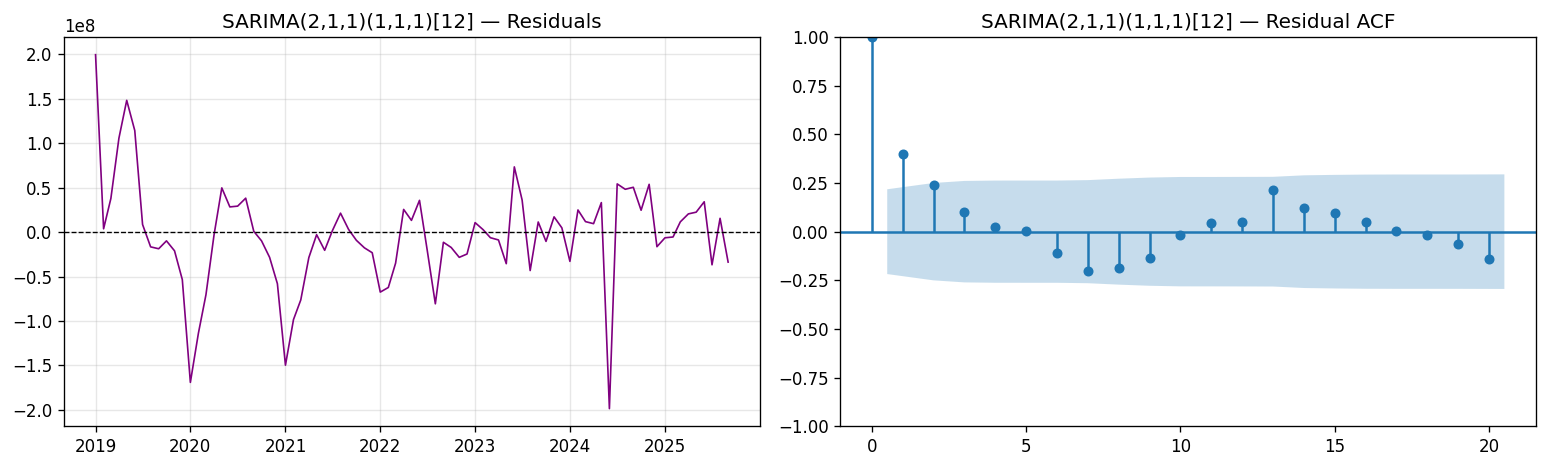

SARIMA(2,1,1)(1,1,1)[12] → {'MAE': 28371894.8, 'RMSE': np.float64(35177419.66), 'MAPE': np.float64(9.5886)} | AIC=2063.64 | Ljung-Box p=0.0013


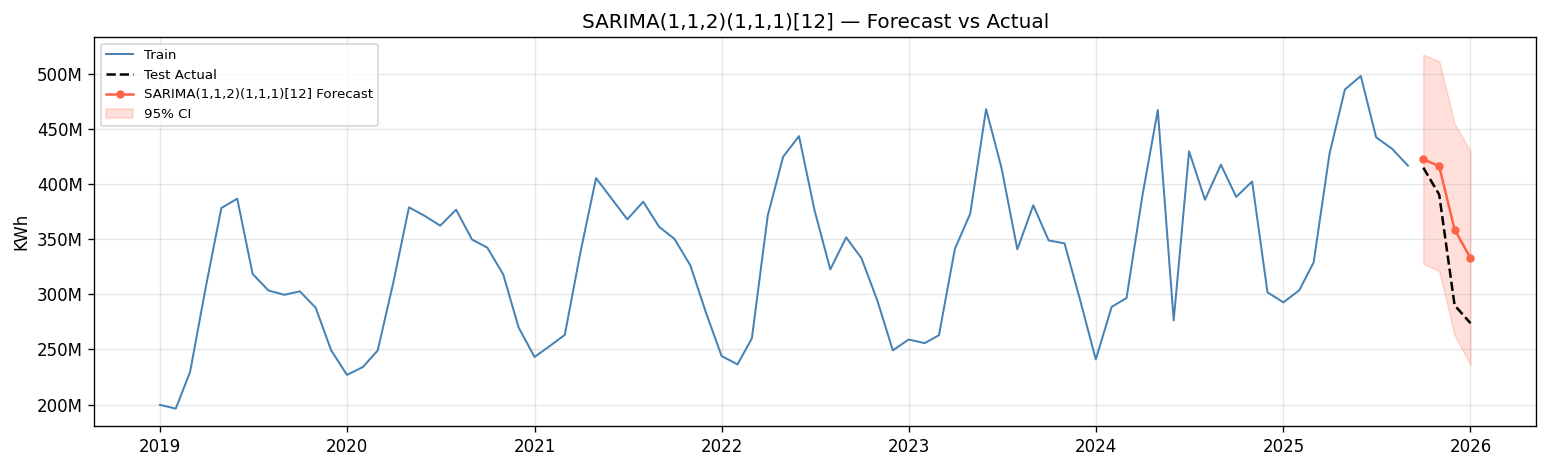

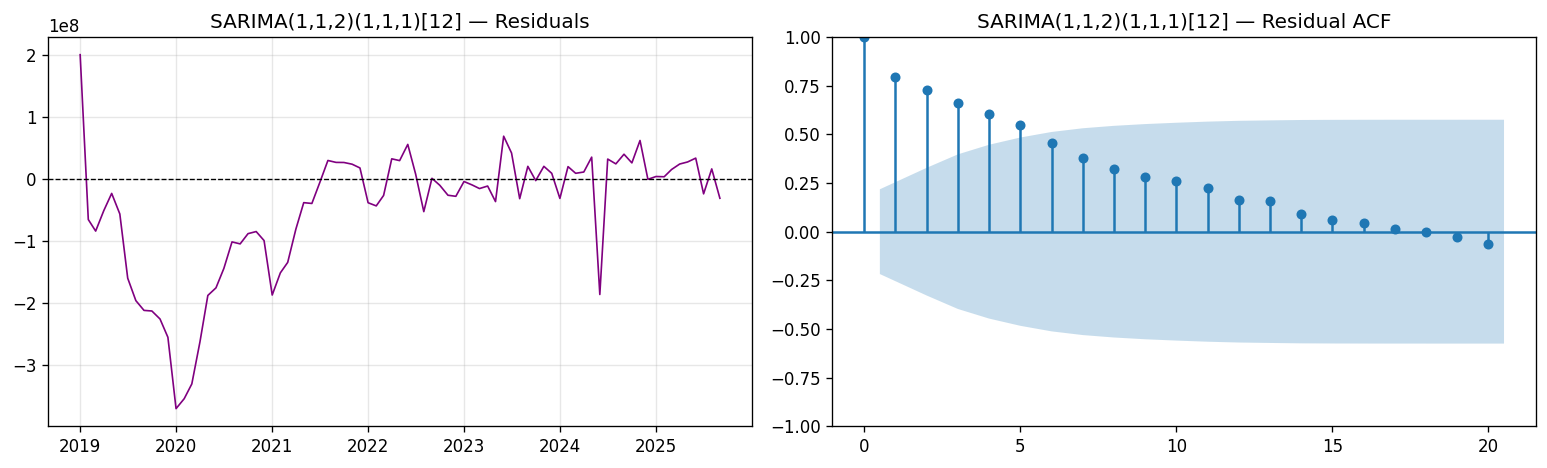

SARIMA(1,1,2)(1,1,1)[12] → {'MAE': 40334604.89, 'RMSE': np.float64(47287554.08), 'MAPE': np.float64(13.4355)} | AIC=2019.03 | Ljung-Box p=0.0


In [17]:
mlflow.set_experiment(EXP_ARIMA)

sarima_candidates = [
    {"order": (1,1,1), "seasonal_order": (1,1,1,12), "run_name": "SARIMA_1_1_1_1_1_1_12"},
    {"order": (1,0,1), "seasonal_order": (1,1,1,12), "run_name": "SARIMA_1_0_1_1_1_1_12"},
    {"order": (2,1,1), "seasonal_order": (1,1,1,12), "run_name": "SARIMA_2_1_1_1_1_1_12"},
    {"order": (1,1,2), "seasonal_order": (1,1,1,12), "run_name": "SARIMA_1_1_2_1_1_1_12"},
]

for candidate in sarima_candidates:
    with mlflow.start_run(run_name=candidate["run_name"]):
        try:
            sarima_model = SARIMAX(
                train,
                order=candidate["order"],
                seasonal_order=candidate["seasonal_order"],
                enforce_stationarity=False,
                enforce_invertibility=False,
            ).fit(disp=False)

            p, d, q = candidate["order"]
            P, D, Q, m = candidate["seasonal_order"]
            label = f"SARIMA({p},{d},{q})({P},{D},{Q})[{m}]"

            # Forecast on test set
            forecast_res = sarima_model.get_forecast(steps=len(test))
            forecast_vals = forecast_res.predicted_mean
            conf_int = forecast_res.conf_int()
            metrics = compute_metrics(test.values, forecast_vals.values)

            mlflow.set_tag("model_family", "sarima")
            mlflow.set_tag("model_variant", label)
            mlflow.set_tag("outlier_fixed", "True")
            mlflow.log_params({
                "model_type": "SARIMA_manual",
                "p": p, "d": d, "q": q,
                "P": P, "D": D, "Q": Q, "m": m,
                "forecast_horizon": FORECAST_HORIZON,
            })
            mlflow.log_metrics(metrics)
            mlflow.log_metric("AIC", round(sarima_model.aic, 4))
            mlflow.log_metric("BIC", round(sarima_model.bic, 4))

            # Forecast plot with confidence interval
            fig, ax = plt.subplots(figsize=(13, 4))
            ax.plot(train.index, train, label="Train", color="steelblue", linewidth=1.2)
            ax.plot(test.index, test, label="Test Actual", color="black",
                    linewidth=1.5, linestyle="--")
            ax.plot(forecast_vals.index, forecast_vals, label=f"{label} Forecast",
                    color="tomato", linewidth=1.5, marker="o", markersize=4)
            ax.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                            alpha=0.2, color="tomato", label="95% CI")
            ax.set_title(f"{label} — Forecast vs Actual")
            ax.set_ylabel("KWh")
            ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
            ax.legend(fontsize=8)
            ax.grid(alpha=0.3)
            plt.tight_layout()
            fname = f"11_{candidate['run_name']}_forecast.png"
            plt.savefig(fname, bbox_inches="tight")
            plt.show()
            mlflow.log_artifact(fname)

            residuals = pd.Series(sarima_model.resid, index=train.index)
            plot_residuals(residuals, label, f"11_{candidate['run_name']}_residuals.png")
            mlflow.log_artifact(f"11_{candidate['run_name']}_residuals.png")

            lb = ljung_box_test(residuals)
            mlflow.log_metrics(lb)

            model_path = save_model_artifact(sarima_model, f"{candidate['run_name']}.pkl")
            mlflow.log_artifact(model_path, artifact_path="model")

            print(f"{label} → {metrics} | AIC={sarima_model.aic:.2f} | Ljung-Box p={lb['lb_pvalue']}")

        except Exception as e:
            print(f"Failed {candidate['run_name']}: {e}")


## 17. Model Comparison — MLflow Results Summary

In [18]:
import mlflow

def fetch_experiment_runs(experiment_name: str) -> pd.DataFrame:
    exp = mlflow.get_experiment_by_name(experiment_name)
    if exp is None:
        return pd.DataFrame()
    runs = mlflow.search_runs(experiment_ids=[exp.experiment_id])
    return runs

cols_needed = ["tags.mlflow.runName", "metrics.MAPE", "metrics.RMSE",
               "metrics.MAE", "metrics.AIC", "metrics.BIC",
               "metrics.lb_pvalue", "tags.model_family"]

runs_smooth = fetch_experiment_runs(EXP_SMOOTHING)
runs_arima  = fetch_experiment_runs(EXP_ARIMA)

all_runs = pd.concat([runs_smooth, runs_arima], ignore_index=True)

available_cols = [c for c in cols_needed if c in all_runs.columns]
summary = (
    all_runs[available_cols]
    .rename(columns={
        "tags.mlflow.runName": "Model",
        "metrics.MAPE": "MAPE(%)",
        "metrics.RMSE": "RMSE",
        "metrics.MAE": "MAE",
        "metrics.AIC": "AIC",
        "metrics.BIC": "BIC",
        "metrics.lb_pvalue": "LjungBox_p",
        "tags.model_family": "Family",
    })
    .sort_values("MAPE(%)")
    .reset_index(drop=True)
)

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
print("\n===== MODEL COMPARISON (sorted by MAPE) =====\n")
print(summary.to_string(index=False))
summary.to_csv("12_model_comparison.csv", index=False)
print("\nSaved: 12_model_comparison.csv")



===== MODEL COMPARISON (sorted by MAPE) =====

                   Model  MAPE(%)           RMSE           MAE      AIC      BIC  LjungBox_p                Family
HW_Multiplicative_Damped     5.44  21,069,970.19 15,960,064.34 2,805.38 2,846.09        1.00          holt_winters
   SARIMA_1_0_1_1_1_1_12     5.83  21,485,524.78 17,885,675.59 2,095.68 2,105.72        0.00                sarima
       HW_Multiplicative     6.59  25,237,369.89 19,180,283.43 2,804.14 2,842.46        0.99          holt_winters
             SARIMA_auto     8.40  28,538,307.72 26,380,409.63 2,629.64 2,634.10        0.00                sarima
      HW_Additive_Damped     9.21  33,232,852.59 27,219,741.51 2,816.52 2,857.23        0.93          holt_winters
   SARIMA_1_1_1_1_1_1_12     9.52  35,121,415.79 28,068,649.38 2,061.74 2,071.69        0.00                sarima
   SARIMA_2_1_1_1_1_1_12     9.59  35,177,419.66 28,371,894.80 2,063.64 2,075.57        0.00                sarima
             HW_Additive    10.4

## 18. Final Forecast — Best Model on Full Data
Retrain the best-performing model on the **full dataset** (train + test)
and forecast the next 3 months (Feb–Apr 2026).


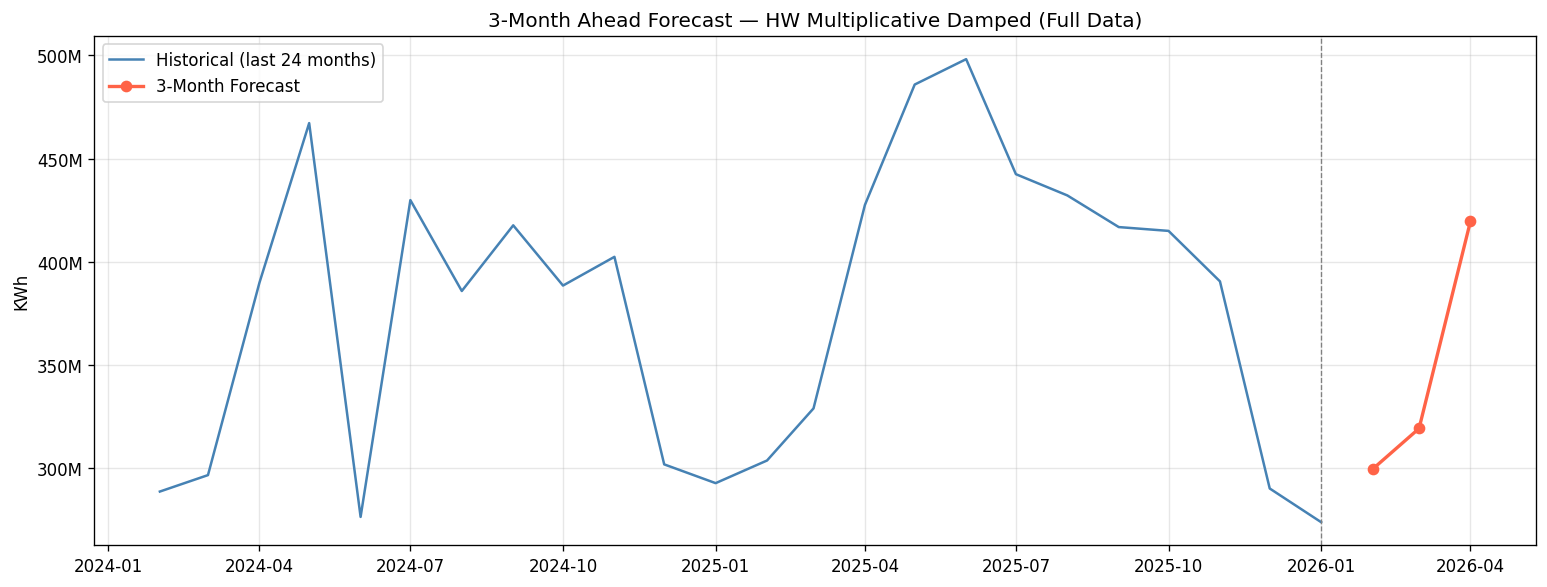


===== FINAL 3-MONTH FORECAST =====
  2026-02: 299,509,239 KWh
  2026-03: 319,217,660 KWh
  2026-04: 419,617,476 KWh


In [19]:
# ── Retrain best model (update manually after reviewing comparison table above)
# Default: HW_Multiplicative_Damped — update run_name if SARIMA wins

BEST_MODEL_TYPE = "holt_winters"   # change to "sarima" if SARIMA wins

full_series = df["total_units_kwh"]
future_index = pd.date_range(start="2026-02-01", periods=FORECAST_HORIZON, freq="MS")

if BEST_MODEL_TYPE == "holt_winters":
    best_model = ExponentialSmoothing(
        full_series,
        trend="add",
        damped_trend=True,
        seasonal="mul",
        seasonal_periods=SEASONAL_PERIOD,
        initialization_method="estimated",
    ).fit(optimized=True)
    final_forecast = best_model.forecast(FORECAST_HORIZON)
    final_forecast.index = future_index
    model_label = "HW Multiplicative Damped (Full Data)"

elif BEST_MODEL_TYPE == "sarima":
    # Update order below based on auto_arima result
    best_model = SARIMAX(
        full_series,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
    forecast_res = best_model.get_forecast(steps=FORECAST_HORIZON)
    final_forecast = forecast_res.predicted_mean
    final_forecast.index = future_index
    model_label = "SARIMA(1,1,1)(1,1,1)[12] (Full Data)"

# Log final forecast run
mlflow.set_experiment(EXP_SMOOTHING if BEST_MODEL_TYPE == "holt_winters" else EXP_ARIMA)
with mlflow.start_run(run_name=f"FINAL_FORECAST_{BEST_MODEL_TYPE.upper()}"):
    mlflow.set_tag("model_family", BEST_MODEL_TYPE)
    mlflow.set_tag("stage", "production_forecast")
    mlflow.set_tag("trained_on", "full_data_2019_2026")
    mlflow.log_param("forecast_horizon", FORECAST_HORIZON)
    mlflow.log_param("forecast_start", str(future_index[0].date()))
    mlflow.log_param("forecast_end",   str(future_index[-1].date()))

    for i, (dt, val) in enumerate(zip(future_index, final_forecast), 1):
        mlflow.log_metric(f"forecast_month_{i}", round(val, 2))

    # Plot
    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(full_series.index[-24:], full_series.iloc[-24:],
            label="Historical (last 24 months)", color="steelblue", linewidth=1.5)
    ax.plot(final_forecast.index, final_forecast, label="3-Month Forecast",
            color="tomato", linewidth=2, marker="o", markersize=6)
    ax.axvline(full_series.index[-1], linestyle="--", color="gray", linewidth=0.8)
    ax.set_title(f"3-Month Ahead Forecast — {model_label}")
    ax.set_ylabel("KWh")
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f}M"))
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("13_final_forecast.png", bbox_inches="tight")
    plt.show()
    mlflow.log_artifact("13_final_forecast.png")

    print("\n===== FINAL 3-MONTH FORECAST =====")
    for dt, val in zip(future_index, final_forecast):
        print(f"  {dt.strftime('%Y-%m')}: {val:,.0f} KWh")


## 19. View Results in MLflow UI
Run the following command in your terminal to launch the MLflow tracking UI:
```bash
mlflow ui --port 5000
```
Then open: http://localhost:5000

Navigate to experiments `exponential_smoothing` and `arima_sarima` to compare all runs by MAPE, RMSE, AIC, and Ljung-Box p-value.
